In [44]:
import os
import json
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union
import sys
sys.dont_write_bytecode = True
from utils import plot_layer_profiling, plot_layer_profiling_dist, COLOR_MAP, get_colors

/home/yli927/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# bert_latency_res = pd.read_csv('profile_res/latency_bert-base-uncased_res.csv')
gpt2_latency_res = pd.read_csv('profile_res/latency_gpt2_res.csv')
# bart_latency_res = pd.read_csv('profile_res/latency_bart-base_res.csv')

# bert_memory_res = pd.read_csv('profile_res/memory_bert-base-uncased_res.csv')
gpt2_memory_res = pd.read_csv('profile_res/memory_gpt2_res.csv')
# bart_memory_res = pd.read_csv('profile_res/memory_bart-base_res.csv')

In [48]:
def plot_layer_profiling_split(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
    unit: str = 'seconds',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Create custom patches for legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]
    
    # Split data based on input_length
    # Quantiles for splitting
    # q1 = profile_res['input_length'].quantile(0.1)
    # q2 = profile_res['input_length'].quantile(0.5)
    # small_data = profile_res[profile_res['input_length'] <= q1].drop(columns=['batch_size', 'input_length'])
    # normal_data = profile_res[(profile_res['input_length'] > q1) & (profile_res['input_length'] <= q2)].drop(columns=['batch_size', 'input_length'])
    # large_data = profile_res[profile_res['input_length'] > q2].drop(columns=['batch_size', 'input_length'])
    small_data = profile_res[profile_res['input_length'] <= 128].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    normal_data = profile_res[(profile_res['input_length'] > 128) & (profile_res['input_length'] <= 512)].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    large_data = profile_res[profile_res['input_length'] > 512].drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    
    plt.figure(figsize=(15, 15))
    data_splits = [('Small', small_data), ('Normal', normal_data), ('Large', large_data)]
    for i, (split_name, data) in enumerate(data_splits, 1):
        plt.subplot(3, 1, i)
        
        # Determine the color of each column based on its label
        column_colors = [color_map['embedding_layer'] if 'embedding' in idx 
                        else color_map['ln_1'] if 'ln_1' in idx
                        else color_map['attn'] if 'attn' in idx
                        else color_map['ln_2'] if 'ln_2' in idx
                        else color_map['mlp'] if 'mlp' in idx
                        else color_map['FC_layer'] if 'FC' in idx 
                        else 'grey'  # default color 
                        for idx in data.columns]

        # Box plot of the data without outliers
        boxprops = dict(linestyle='-', linewidth=1)
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        bp = data.boxplot(vert=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False, return_type='dict')
        
        # Coloring the boxes based on the determined colors
        for patch, color in zip(bp['boxes'], column_colors):
            patch.set_facecolor(color)

        plt.ylabel(f'{metric} ({unit})', fontdict={'fontsize': 12})
        plt.xlabel('Layer', fontdict={'fontsize': 12})
        plt.title(f'Distribution of {metric} for {split_name} Input Length in {model_name}')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        
        # Custom legend only for the first subplot
        if i == 1:
            plt.legend(handles=legend_elements, title="Layer type")
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()


In [49]:
def plot_pie_chart(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Extract only the layer columns (excluding batch_size and input_length)
    res = profile_res.drop(columns=['batch_size', 'input_length'], ignore_errors=True)
    
    # Dictionary to store the summed latency for each layer type
    layer_sum = {
        'embedding_layer': 0,
        'ln_1': 0,
        'attn': 0,
        'ln_2': 0,
        'mlp': 0,
        'FC_layer': 0
    }
    
    # Sum up latencies for each layer type
    for column in res.columns:
        if 'embedding' in column:
            layer_sum['embedding_layer'] += res[column].sum()
        elif 'ln_1' in column:
            layer_sum['ln_1'] += res[column].sum()
        elif 'attn' in column:
            layer_sum['attn'] += res[column].sum()
        elif 'ln_2' in column:
            layer_sum['ln_2'] += res[column].sum()
        elif 'mlp' in column:
            layer_sum['mlp'] += res[column].sum()
        elif 'FC' in column:
            layer_sum['FC_layer'] += res[column].sum()
    
    # Pie chart
    plt.figure(figsize=(10, 8))
    # plt.pie(layer_sum.values(), labels=layer_sum.keys(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
    patches, texts, autotexts = plt.pie(layer_sum.values(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
    plt.title(f'Layer-wise Latency Distribution for {model_name}')
    plt.title(f'Percentage of {metric} for different types of layers in {model_name}')
    
    # Add legend
    # legend_labels = [f"{key.replace('_', ' ').title()}" for key in layer_sum.keys()]
    legend_labels = [f"{key}" for key in layer_sum.keys()]
    plt.legend(patches, legend_labels, loc="best", title="Layer Type")
    
    # Improve appearance
    for t in texts:
        t.set(size=10)
    for at in autotexts:
        at.set(size=10, weight="bold")
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [50]:
def plot_combined_charts(
    profile_res: pd.DataFrame, 
    model_name: str, 
    save_file: str = None,
    color_map: dict = None,
    metric: str = 'inference latency',
    unit: str = 'seconds',
):
    if color_map is None:
        color_map = {
            'embedding_layer': 'blue',
            'ln_1': 'orange',
            'attn': 'purple',
            'ln_2': 'green',
            'mlp': 'brown',
            'FC_layer': 'red',
        }
    
    # Split data into Small, Normal, and Large subsets
    small_data = profile_res[profile_res['input_length'] <= 128].drop(
        columns=['batch_size', 'input_length'], 
        ignore_errors=True,
    )
    normal_data = profile_res[(profile_res['input_length'] > 128) & (profile_res['input_length'] <= 512)].drop(
        columns=['batch_size', 'input_length'],
        ignore_errors=True,
    )
    large_data = profile_res[profile_res['input_length'] > 512].drop(
        columns=['batch_size', 'input_length'], 
        ignore_errors=True,
    )
    
    data_subsets = [small_data, normal_data, large_data]
    subset_names = ['Small', 'Normal', 'Large']
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18), width_ratios=[3, 1])
    
    for i, (data, subset_name) in enumerate(zip(data_subsets, subset_names)):
        # First column: box plots
        column_colors = [color_map['embedding_layer'] if 'embedding' in idx 
                else color_map['ln_1'] if 'ln_1' in idx
                else color_map['attn'] if 'attn' in idx
                else color_map['ln_2'] if 'ln_2' in idx
                else color_map['mlp'] if 'mlp' in idx
                else color_map['FC_layer'] if 'FC' in idx 
                else 'grey' for idx in data.columns]
        
        # Boxplot
        boxprops = dict(linestyle='-', linewidth=1)
        medianprops = dict(linestyle='-', linewidth=2, color='black')
        bp = data.boxplot(ax=axes[i, 0], vert=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False, return_type='dict')
        # Coloring the boxes based on the determined colors
        for patch, color in zip(bp['boxes'], column_colors):
            patch.set_facecolor(color)
            
        axes[i, 0].set_title(f'{subset_name} Input Length: Distribution of Latency for {model_name}')
        axes[i, 0].set_xlabel('Layer', fontdict={'fontsize': 12})
        axes[i, 0].set_ylabel(f'{metric} ({unit})', fontdict={'fontsize': 12})
        axes[i, 0].set_xticklabels(data.columns, rotation=45, ha='right')
        axes[i, 0].grid(axis='y')
        
        # Second column: pie charts
        # Sum up latencies for each layer type
        layer_sum = {
            'embedding_layer': 0,
            'ln_1': 0,
            'attn': 0,
            'ln_2': 0,
            'mlp': 0,
            'FC_layer': 0
        }
        for column in data.columns:
            if 'embedding' in column:
                layer_sum['embedding_layer'] += data[column].sum()
            elif 'ln_1' in column:
                layer_sum['ln_1'] += data[column].sum()
            elif 'attn' in column:
                layer_sum['attn'] += data[column].sum()
            elif 'ln_2' in column:
                layer_sum['ln_2'] += data[column].sum()
            elif 'mlp' in column:
                layer_sum['mlp'] += data[column].sum()
            elif 'FC' in column:
                layer_sum['FC_layer'] += data[column].sum()
        
        # Pie chart
        patches, texts, autotexts = axes[i, 1].pie(layer_sum.values(), autopct='%1.1f%%', startangle=140, colors=[color_map[key] for key in layer_sum.keys()])
        
        # Improve appearance of pie chart
        for t in texts:
            t.set(size=10)
        for at in autotexts:
            at.set(size=10, weight="bold")
    
    # Add legend for pie chart
    legend_labels = [f"{key}" for key in layer_sum.keys()]
    fig.legend(patches, legend_labels, loc='upper right', title="Layer Type")
    
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

In [25]:
if not os.path.exists('figures'):
    os.makedirs('figures')

plot_layer_profiling(
    bert_latency_res, 
    'BERT-base', 
    save_file='figures/bert_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

NameError: name 'bert_latency_res' is not defined

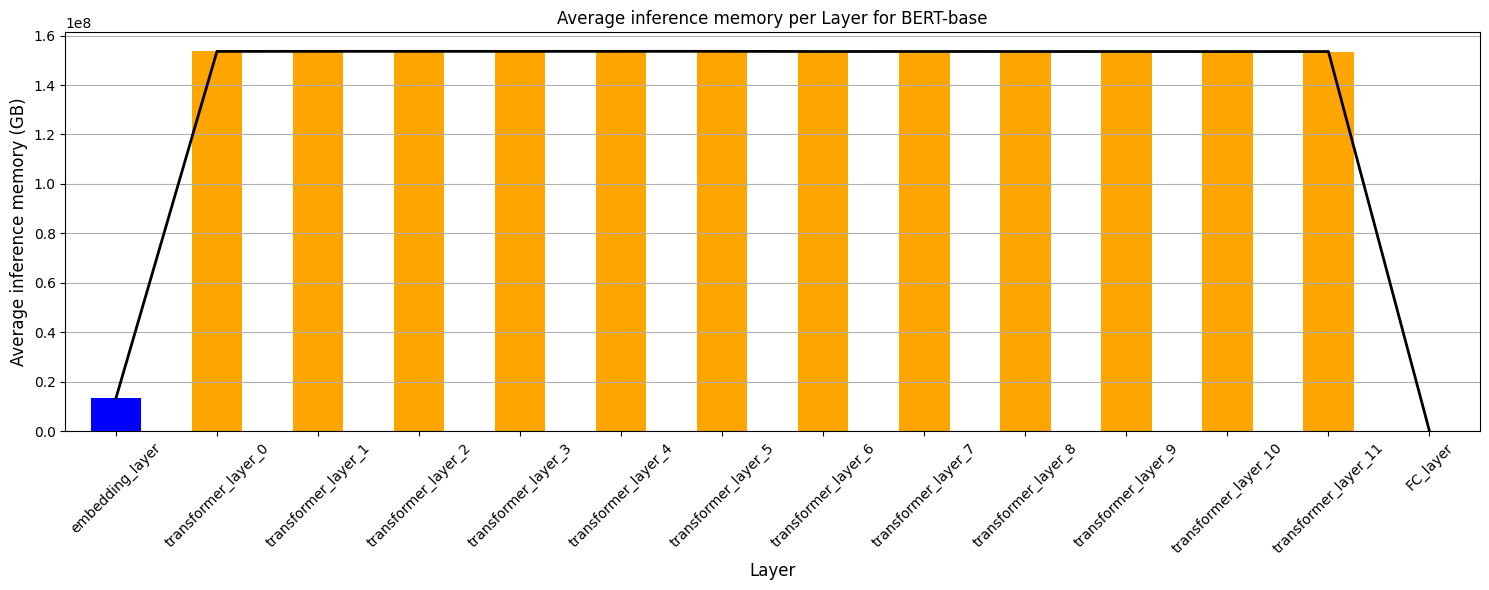

In [47]:
plot_layer_profiling(
    bert_memory_res, 
    'BERT-base', 
    save_file='figures/bert_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

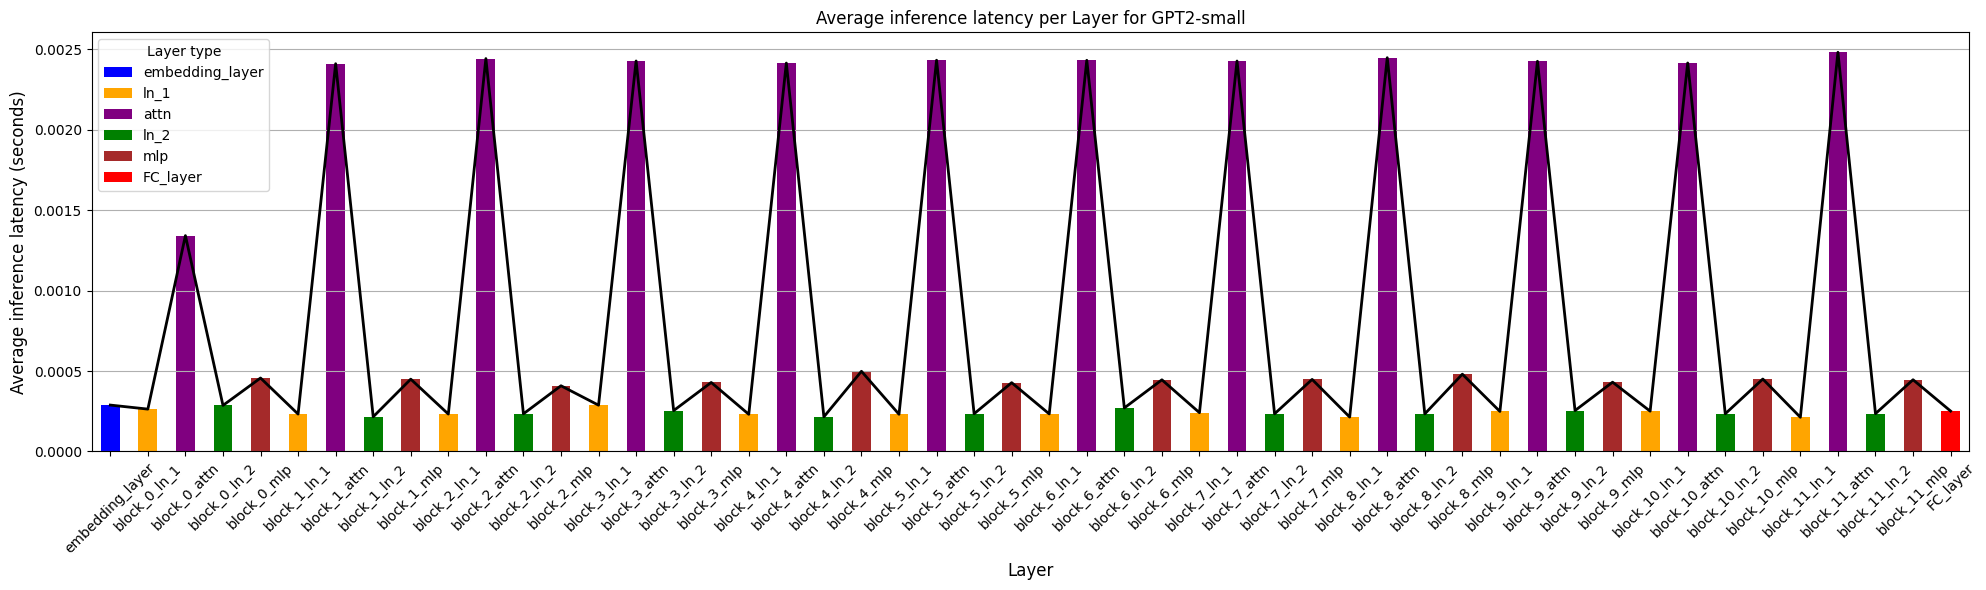

In [43]:
plot_layer_profiling(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

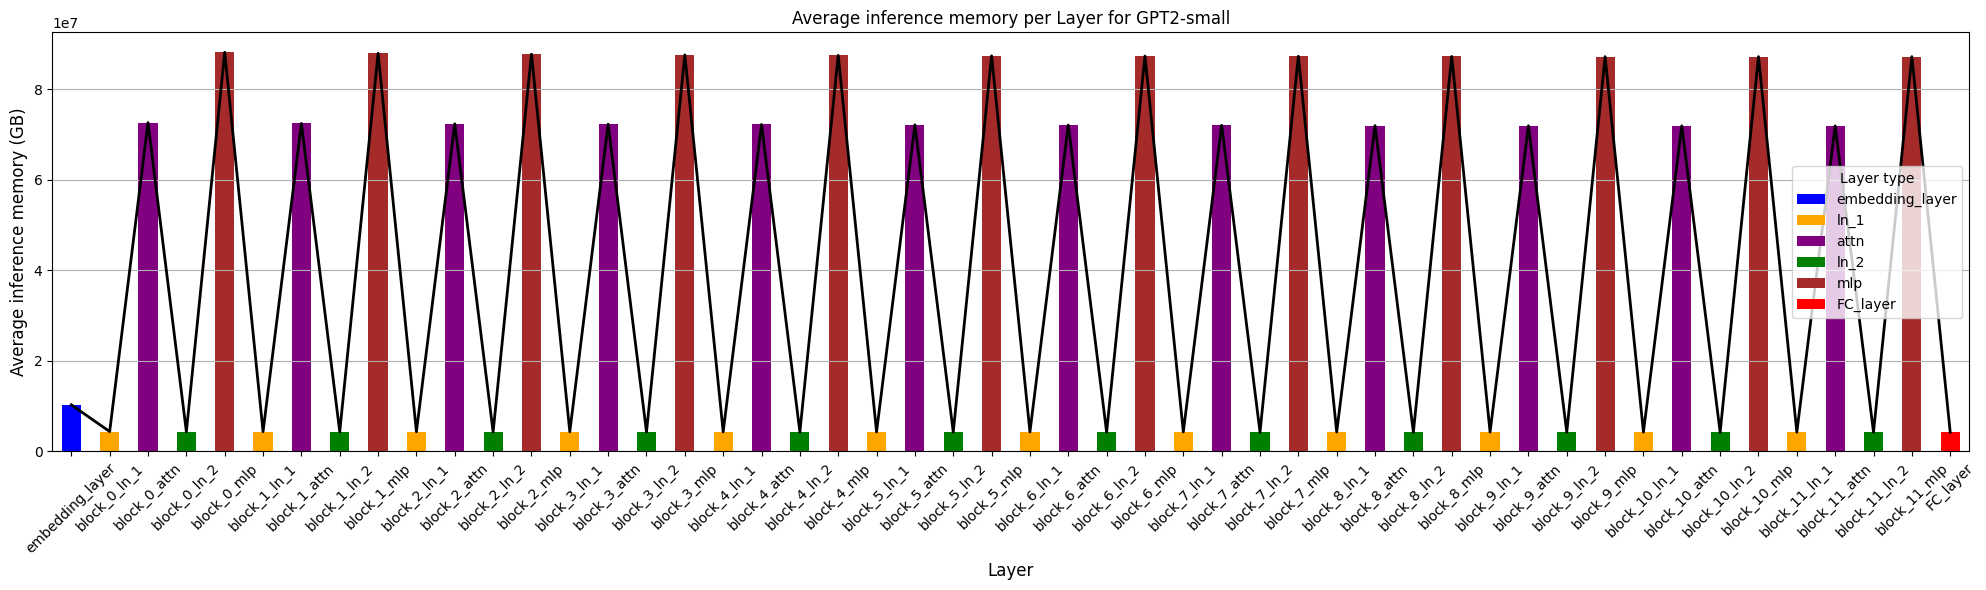

In [44]:
plot_layer_profiling(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

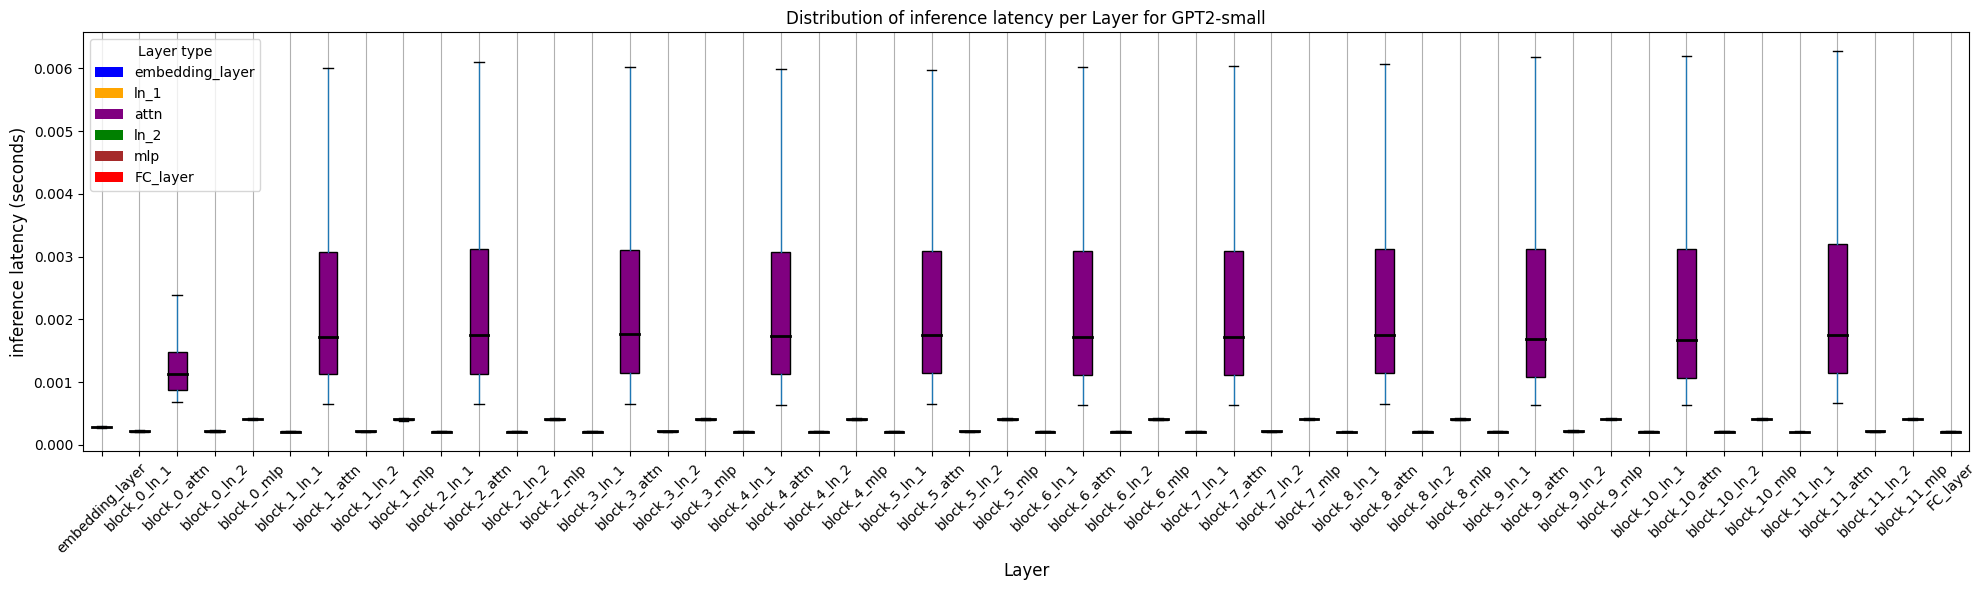

In [45]:
plot_layer_profiling_dist(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency_dist.pdf',
    metric='inference latency',
    unit='seconds',
)

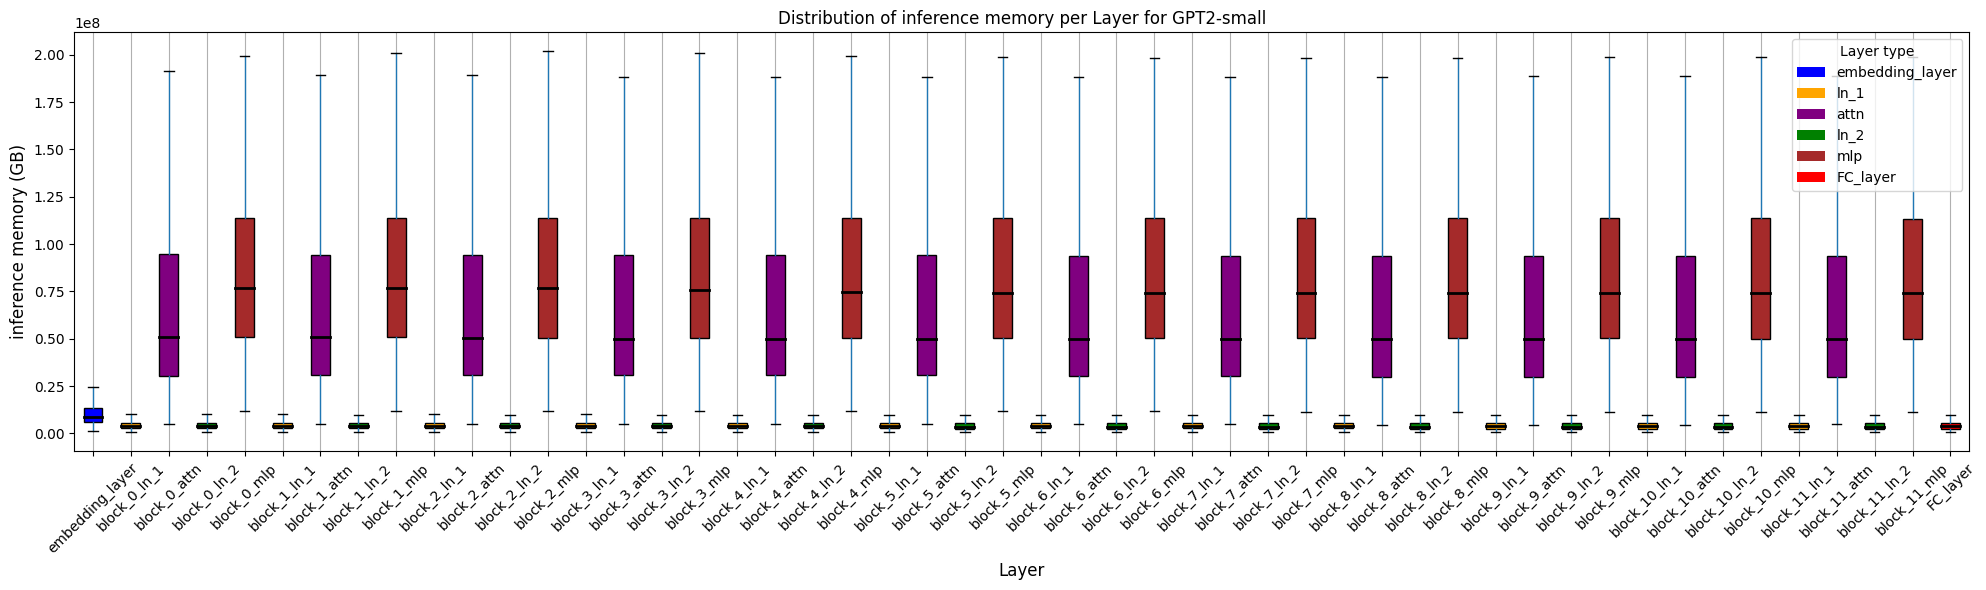

In [46]:
plot_layer_profiling_dist(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory_dist.pdf',
    metric='inference memory',
    unit='GB',
)

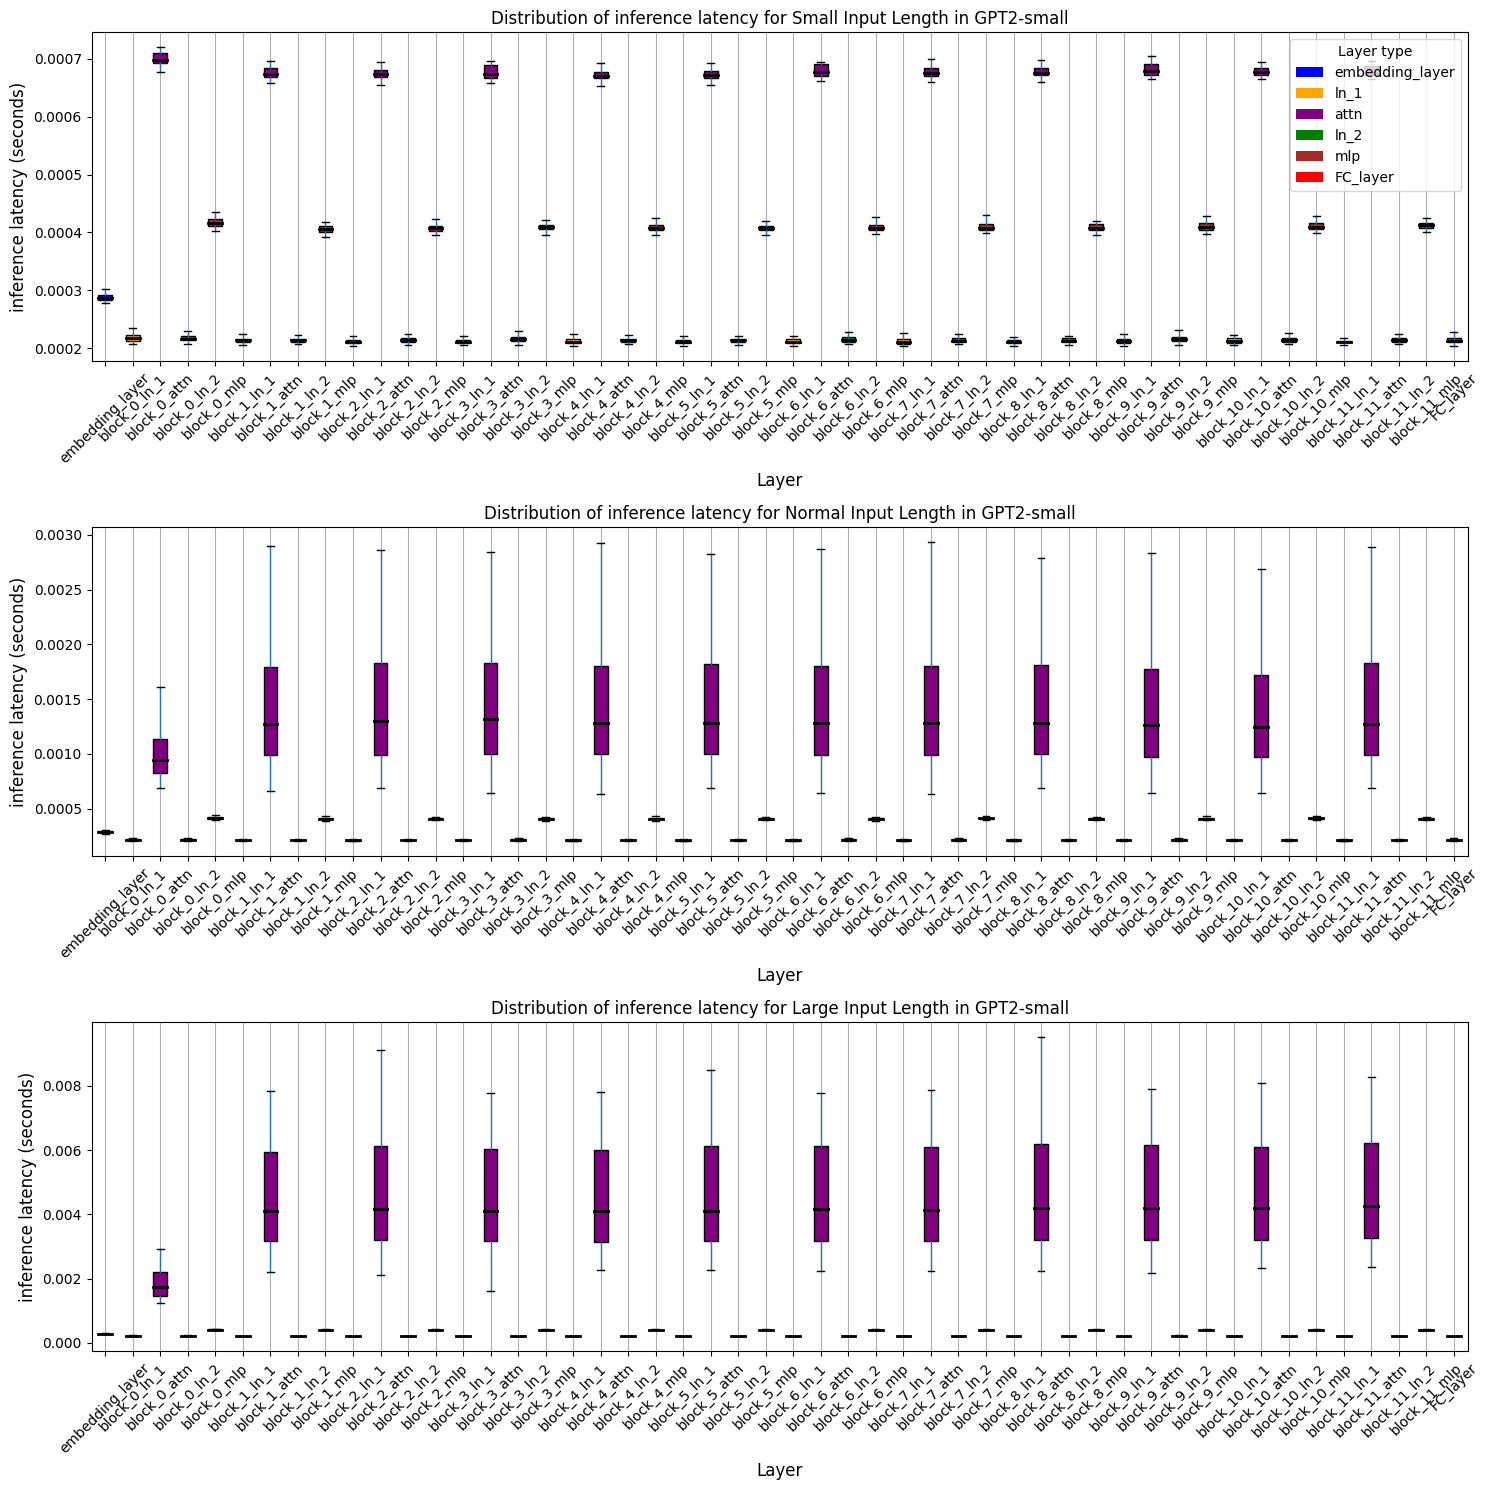

In [56]:
plot_layer_profiling_split(
    gpt2_latency_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_latency_dist_split.pdf',
    metric='inference latency',
    unit='seconds',
)

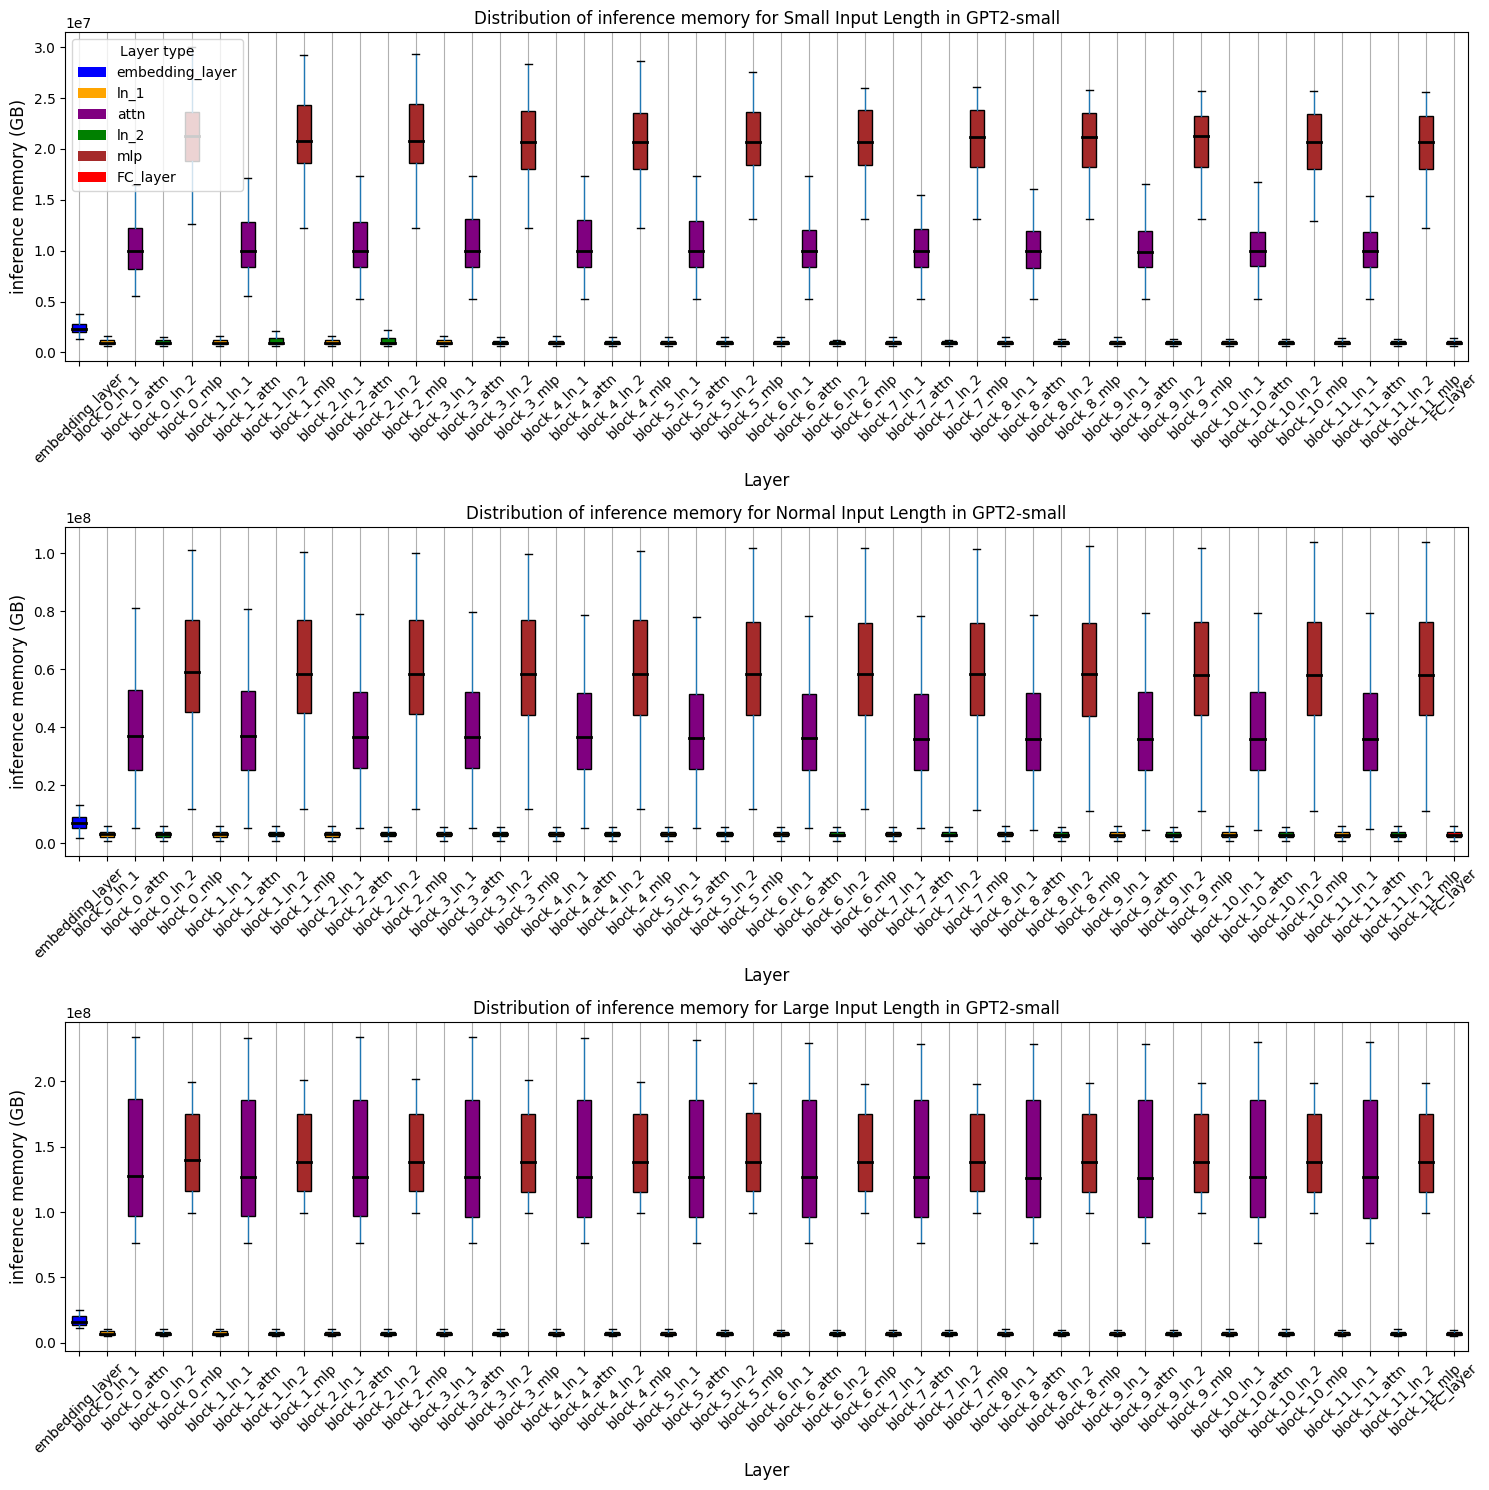

In [57]:
plot_layer_profiling_split(
    gpt2_memory_res, 
    'GPT2-small', 
    save_file='figures/gpt2_layer_memory_dist_split.pdf',
    metric='inference memory',
    unit='GB',
)

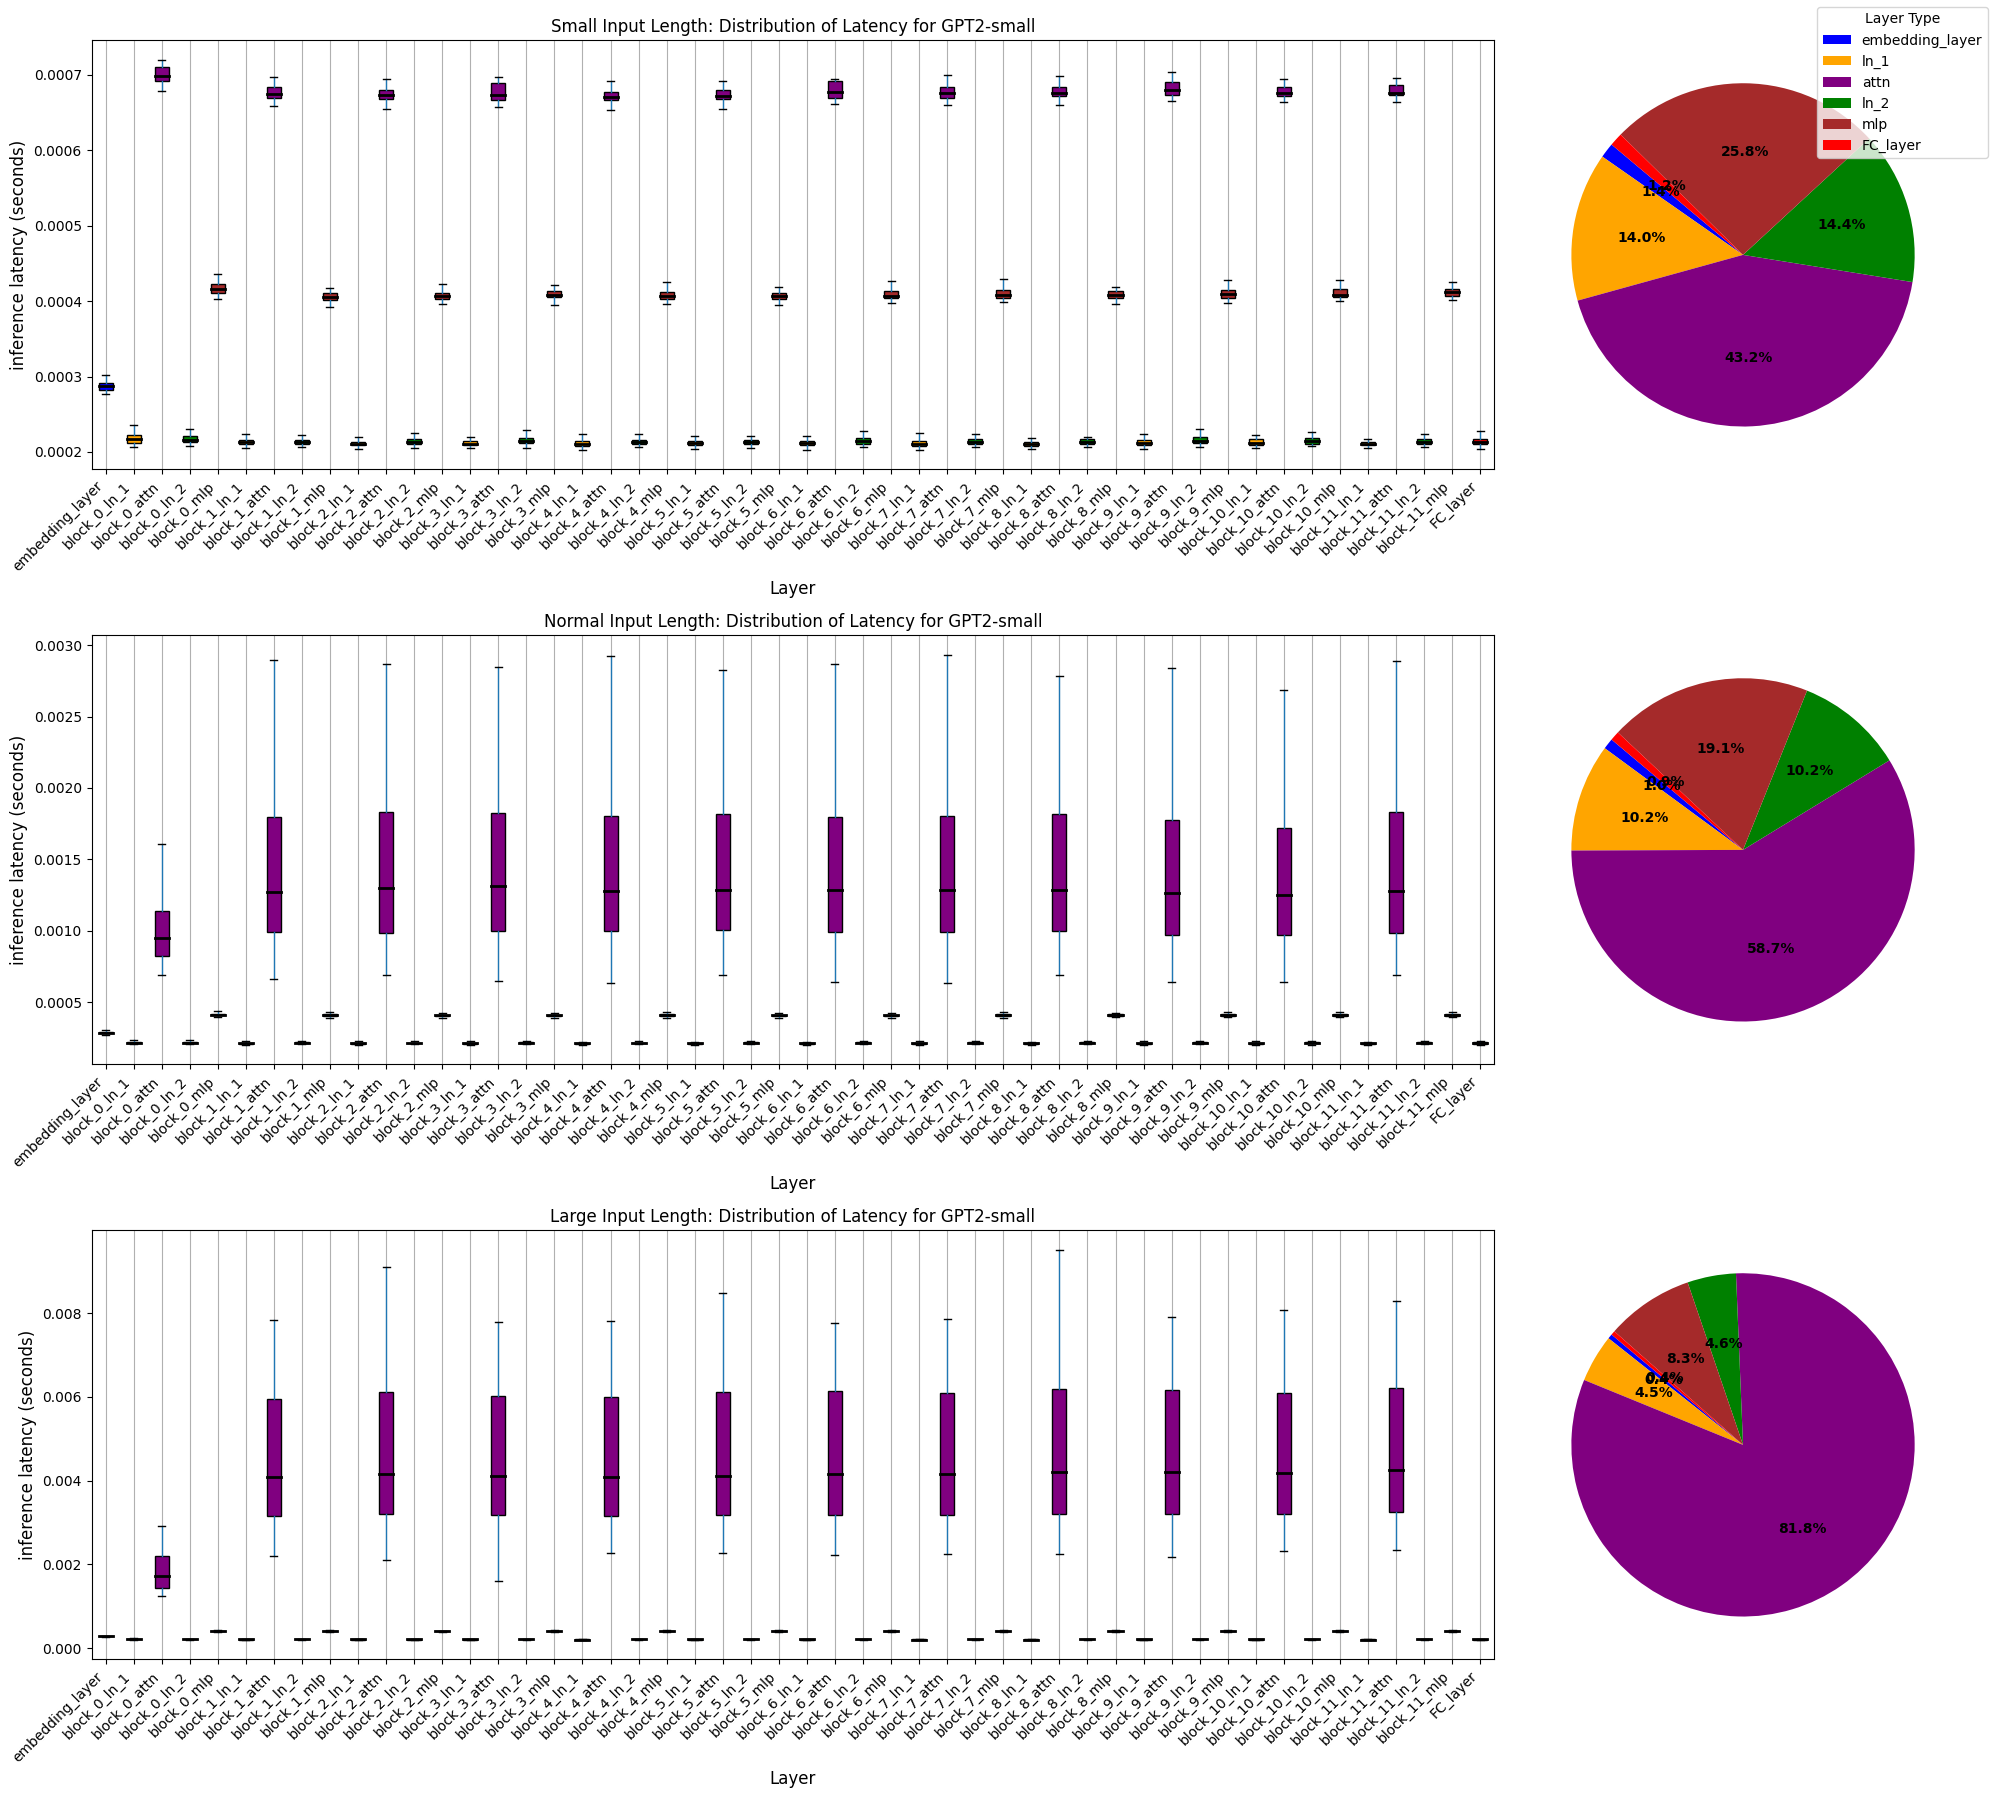

In [87]:
plot_combined_charts(
    gpt2_latency_res,
    'GPT2-small',
    save_file='figures/gpt2_layer_latency_split_combined.pdf',
    metric='inference latency',
    unit='seconds',
)

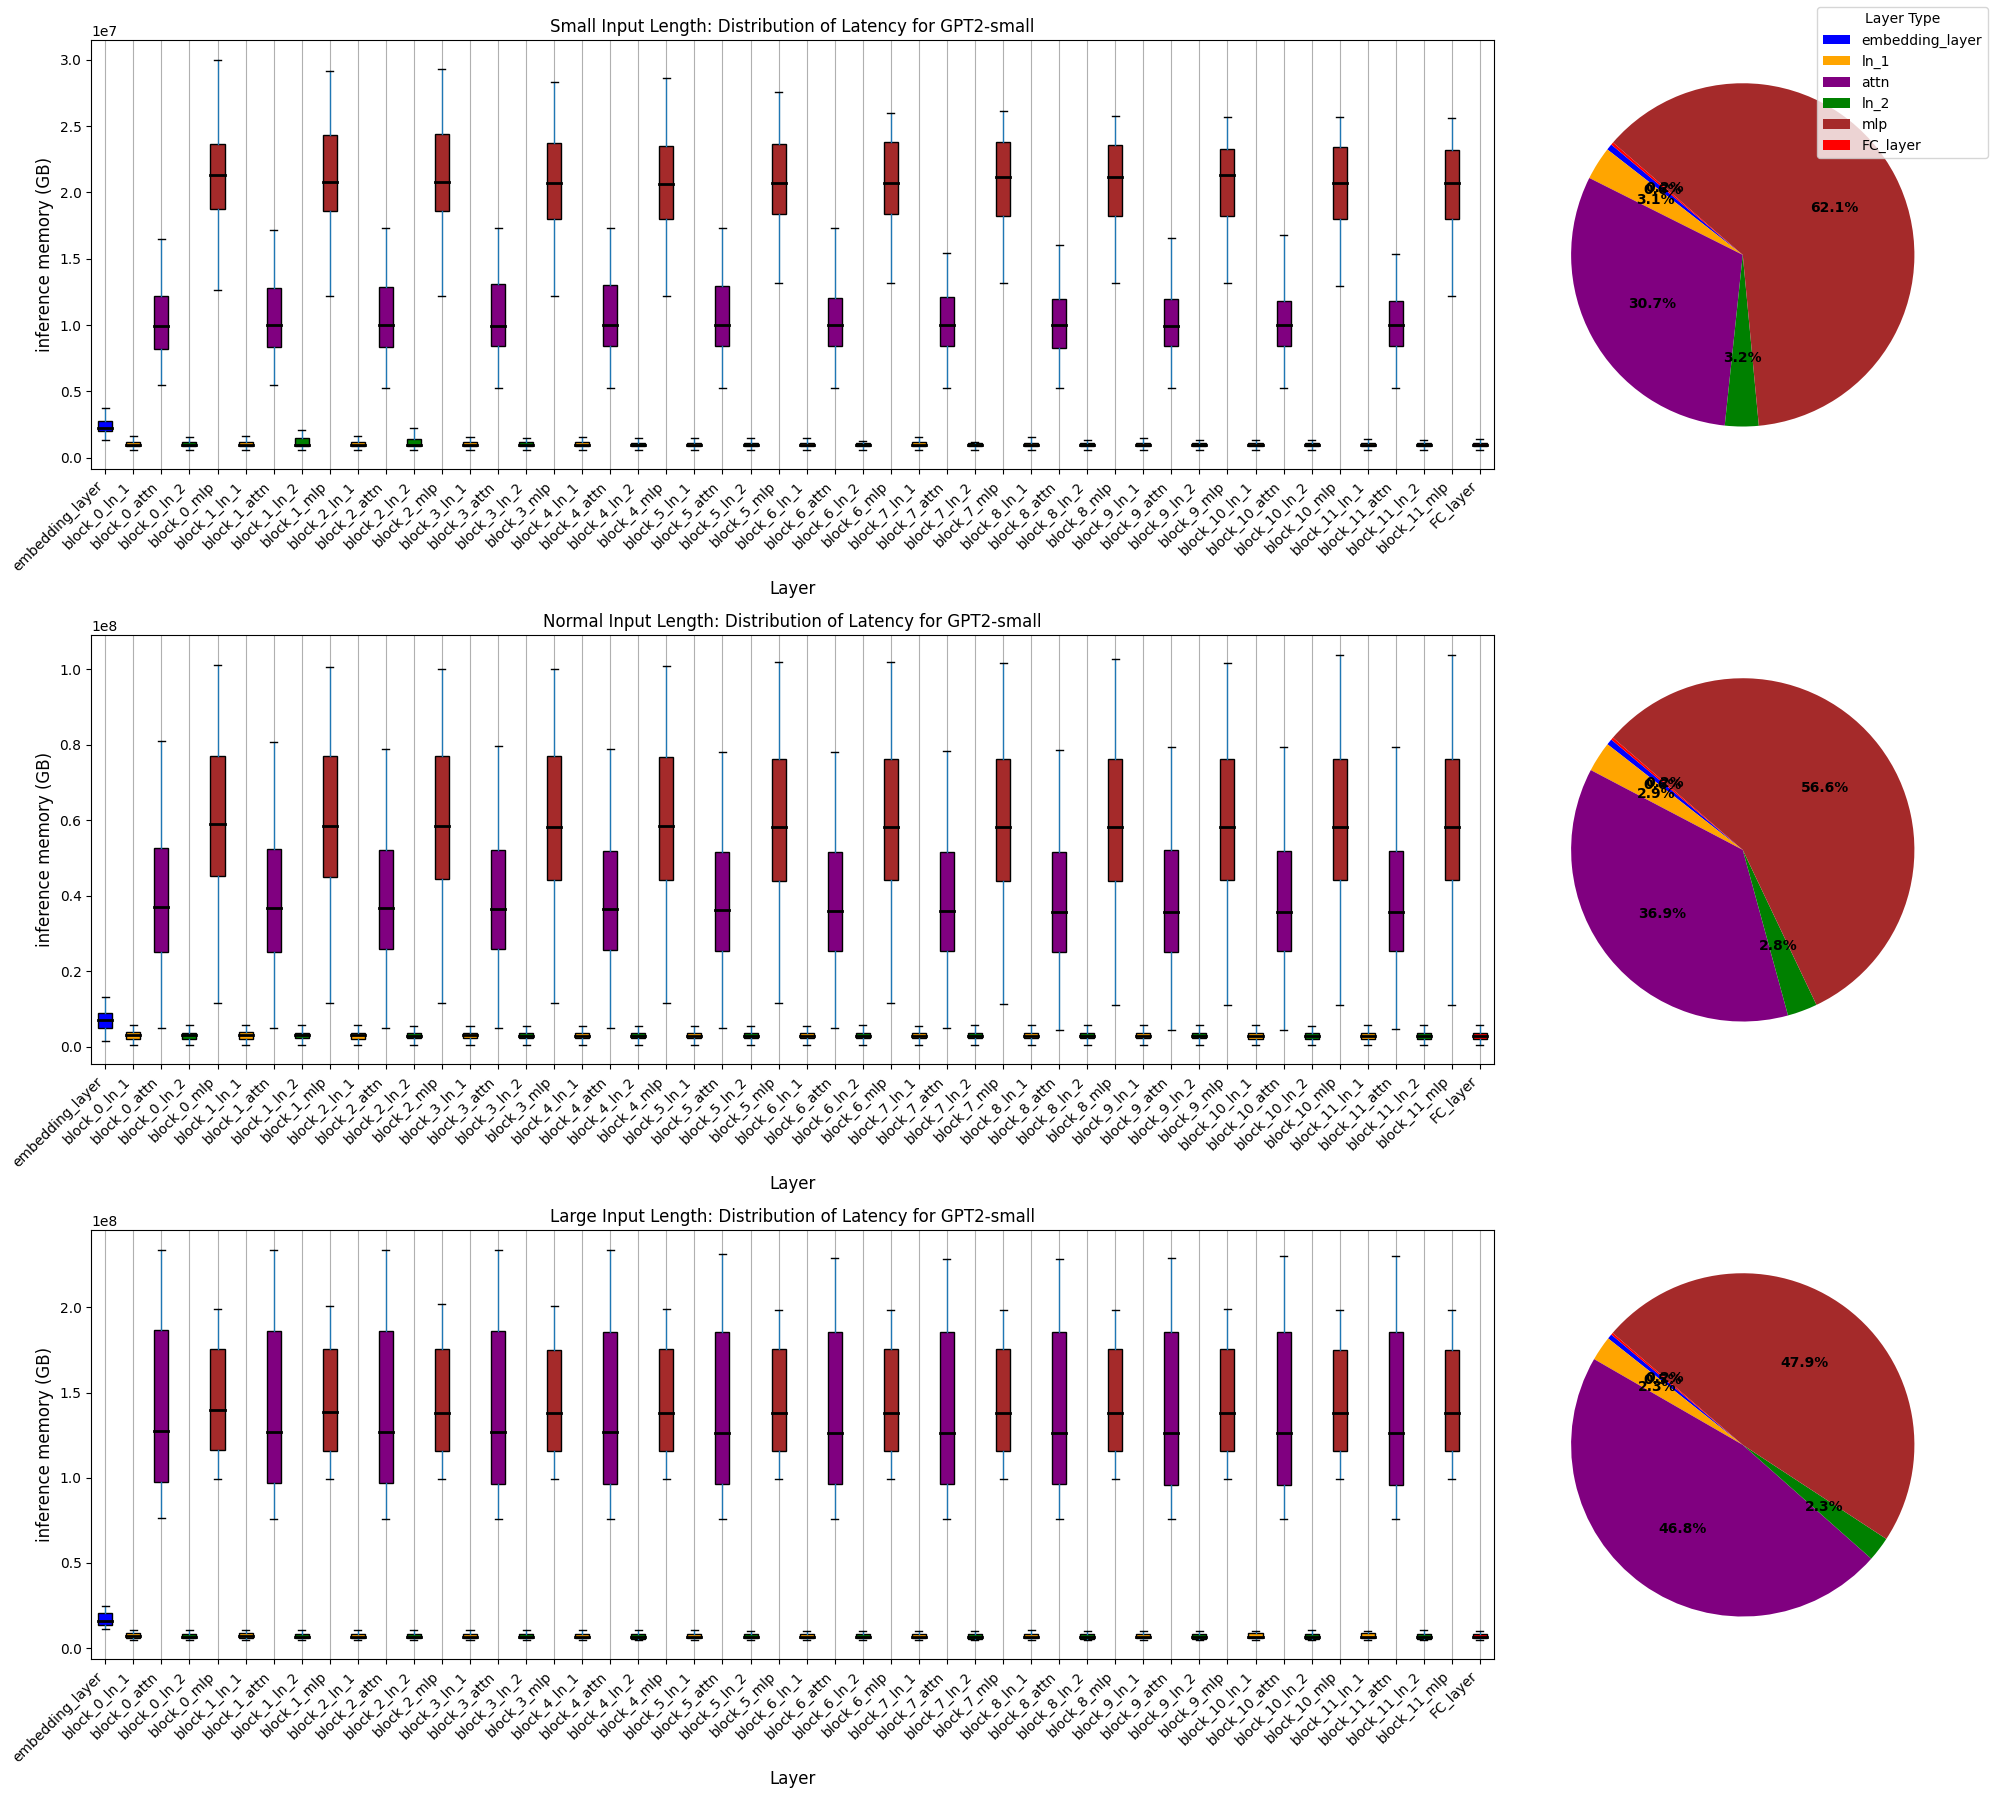

In [88]:
plot_combined_charts(
    gpt2_memory_res,
    'GPT2-small',
    save_file='figures/gpt2_layer_memory_split_combined.pdf',
    metric='inference memory',
    unit='GB',
)

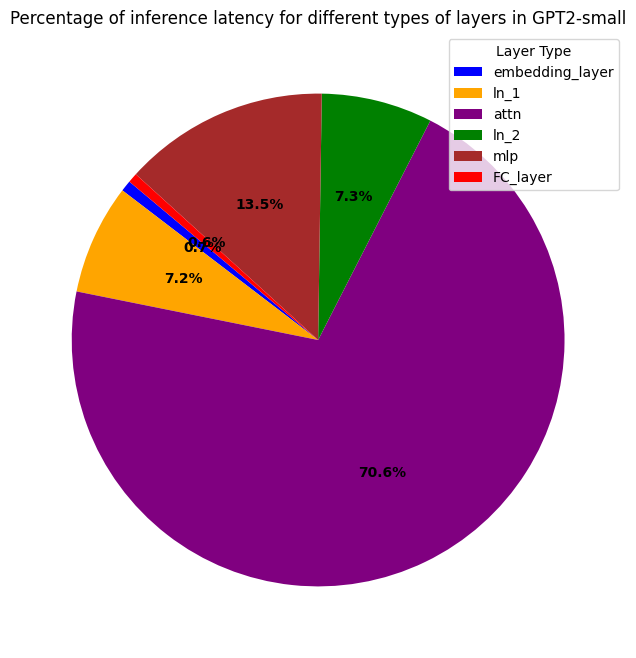

In [68]:
plot_pie_chart(
    gpt2_latency_res,
    'GPT2-small',
    save_file='figures/gpt2_pie_latency.pdf',
    metric='inference latency',
)

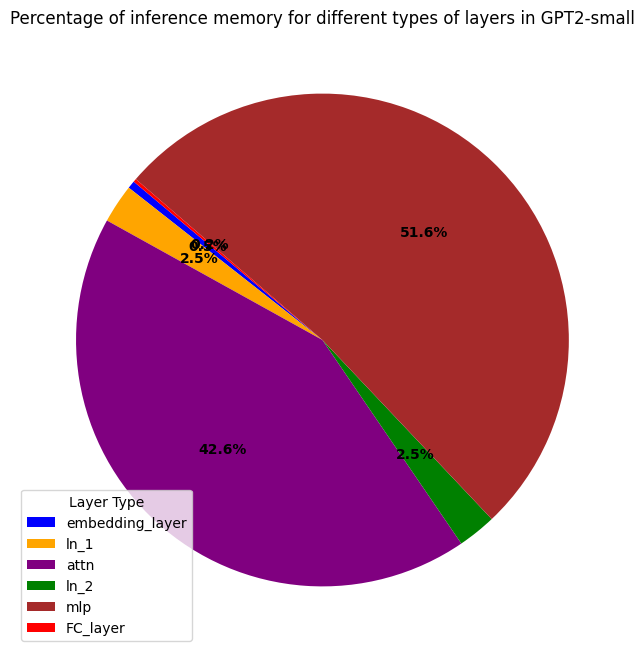

In [69]:
plot_pie_chart(
    gpt2_memory_res,
    'GPT2-small',
    save_file='figures/gpt2_pie_memory.pdf',
    metric='inference memory',
)

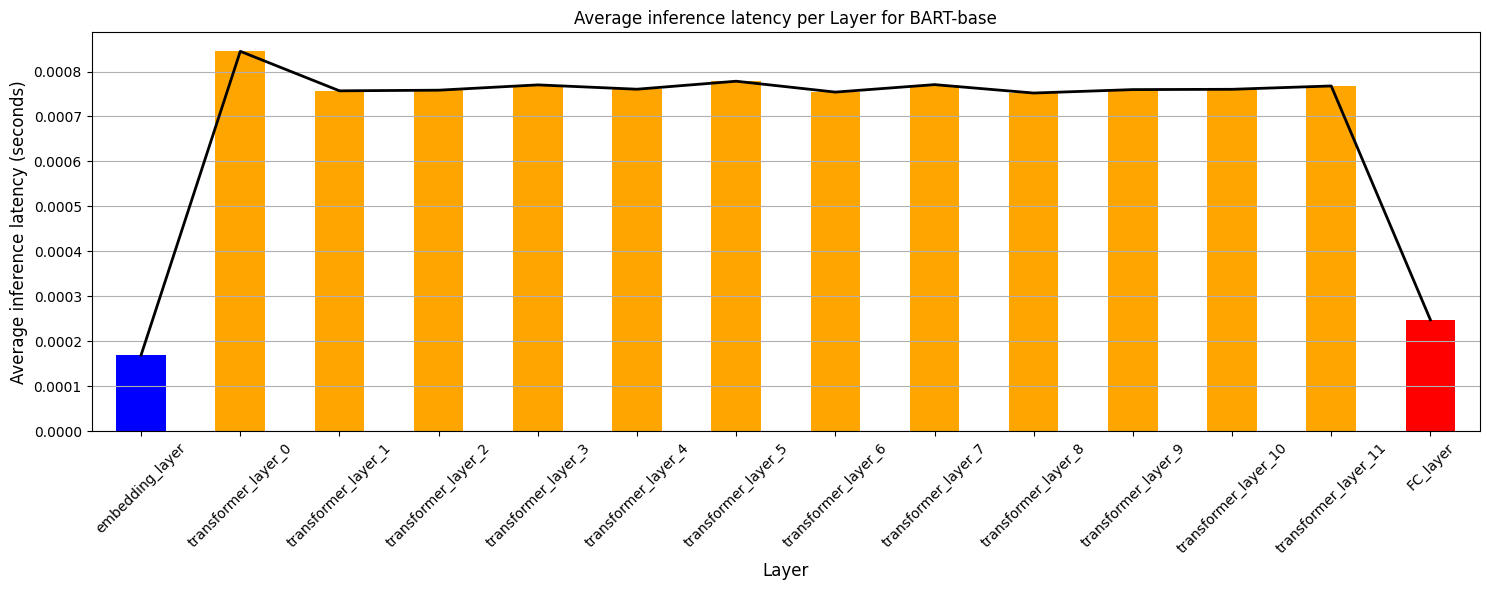

In [50]:
plot_layer_profiling(
    bart_latency_res, 
    'BART-base', 
    save_file='figures/bart_layer_latency.pdf',
    metric='inference latency',
    unit='seconds',
)

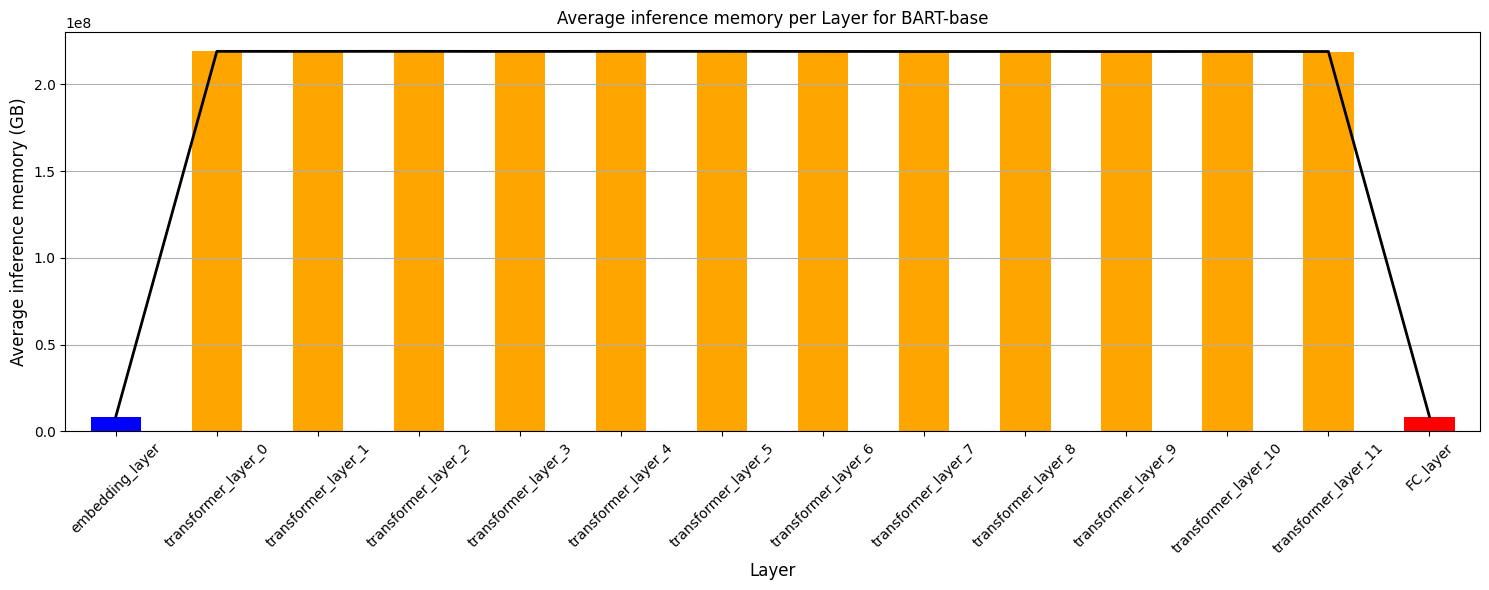

In [51]:
plot_layer_profiling(
    bart_memory_res, 
    'BART-base', 
    save_file='figures/bart_layer_memory.pdf',
    metric='inference memory',
    unit='GB',
)

## Layer profiler

In [73]:
latency_bert = pd.DataFrame(json.load(open('profile_res/latency_forward_bert-base-uncased.json')))
memory_bert = pd.DataFrame(json.load(open('profile_res/memory_forward_bert-base-uncased.json')))
input_len_bert = pd.DataFrame(json.load(open('profile_res/input_length_bert-base-uncased.json')))

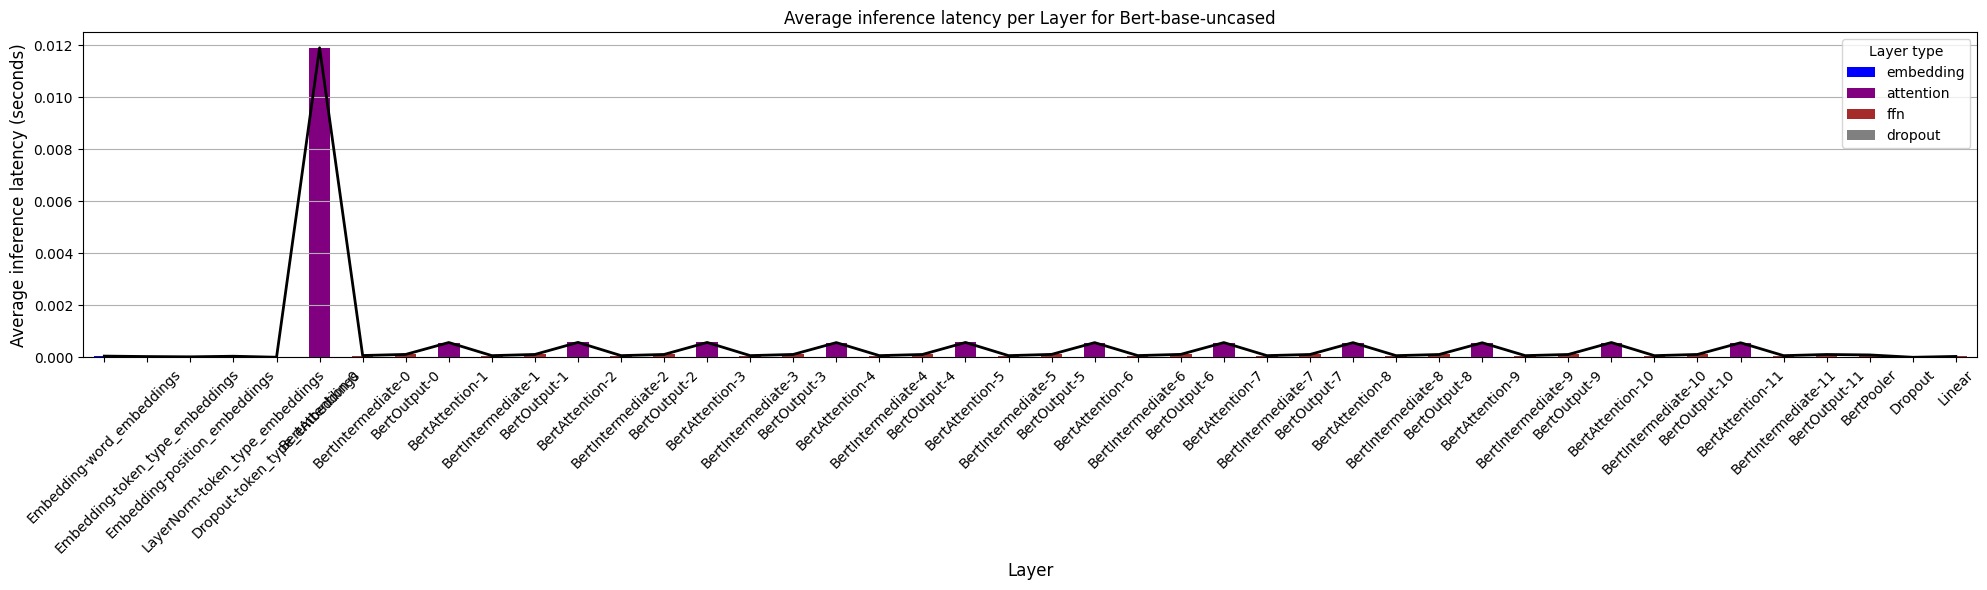

In [74]:
plot_layer_profiling(
    latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_average.pdf',
    metric='inference latency',
    unit='seconds',
)

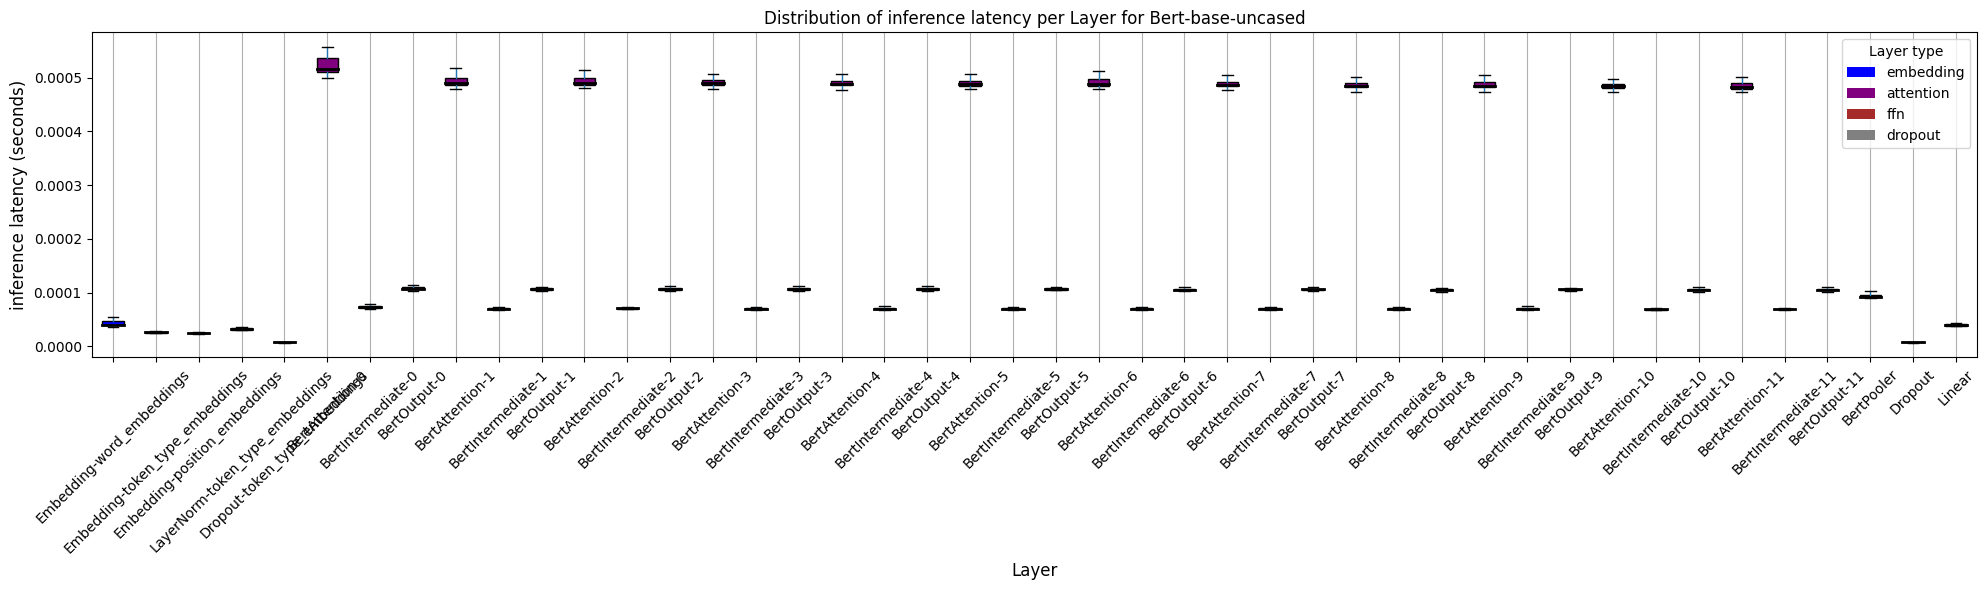

In [75]:
plot_layer_profiling_dist(
    latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_dist.pdf',
    metric='inference latency',
    unit='seconds',
)

### Training

In [5]:
output_dir = 'results/text-classification/bert-base-uncased'
forward_input_len_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_input_length.json')))
forward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_forward_latency.json')))
forward_memory_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_forward_memory.json')))
backward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/train_backward_latency.json')))

In [25]:
COLOR_MAP = {
    'embedding': 'blue',
    'attention': 'purple',
    'ffn': 'brown',
    'dropout': 'grey',
    'backward': 'green',
}

def get_colors(index: List[str], color_map: dict = COLOR_MAP):
    return [
        color_map['embedding'] if 'embedding' in idx.lower() 
        else color_map['attention'] if 'attention' in idx.lower() or 'attn' in idx.lower()
        else color_map['layernorm'] if 'ln' in idx.lower() or 'layernorm' in idx.lower()
        else color_map['ffn'] if (
            'mlp' in idx.lower() or 
            'linear' in idx.lower() or 
            'pooler' in idx.lower() or 
            'intermediate' in idx.lower() or
            'output' in idx.lower()
        )
        else color_map['dropout'] if 'dropout' in idx.lower()
        else color_map['backward'] if 'backward' in idx.lower() or 'bp' in idx.lower()
        else 'red'  # default color 
        for idx in index]

# Plot the average latency distribution of each layer
def plot_layer_profiling(
    profile_res: pd.DataFrame, 
    model_name: str, 
    backward_res: pd.DataFrame = None,
    save_file: str = None,
    color_map: dict = COLOR_MAP,
    metric: str = 'inference latency',
    unit: str = 'seconds',
    figsize: Tuple[int, int] = (20, 6),
):
    # Assuming you have the DataFrame loaded as df (do not include the batch_size, input_length columns)
    if 'batch_size' in profile_res.columns and 'input_length' in profile_res.columns:
        res = profile_res.drop(columns=['batch_size', 'input_length'])
    else:
        res = profile_res
    averages = res.mean()
    if backward_res is not None:
        averages['backward'] = backward_res.mean().tolist()[0]
    
    # Determine the color of each bar based on its label
    colors = get_colors(averages.index)
    
    # Create custom patches for legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[key], label=key) for key in color_map]

    # Plotting
    plt.figure(figsize=figsize)
    averages.plot(kind='bar', color=colors, width=0.5)
    
    # Also plot line graph
    plt.plot(averages, color='black', linestyle='-', linewidth=2)
    
    plt.ylabel(f'Average {metric} ({unit})', fontdict={'fontsize': 12})
    plt.xlabel('Layer', fontdict={'fontsize': 12})
    plt.title(f'Average {metric} per Layer for {model_name}')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    
    # Add legend for the 6 layers
    plt.legend(handles=legend_elements, title="Layer type")
    plt.tight_layout()
    
    if save_file:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show() 

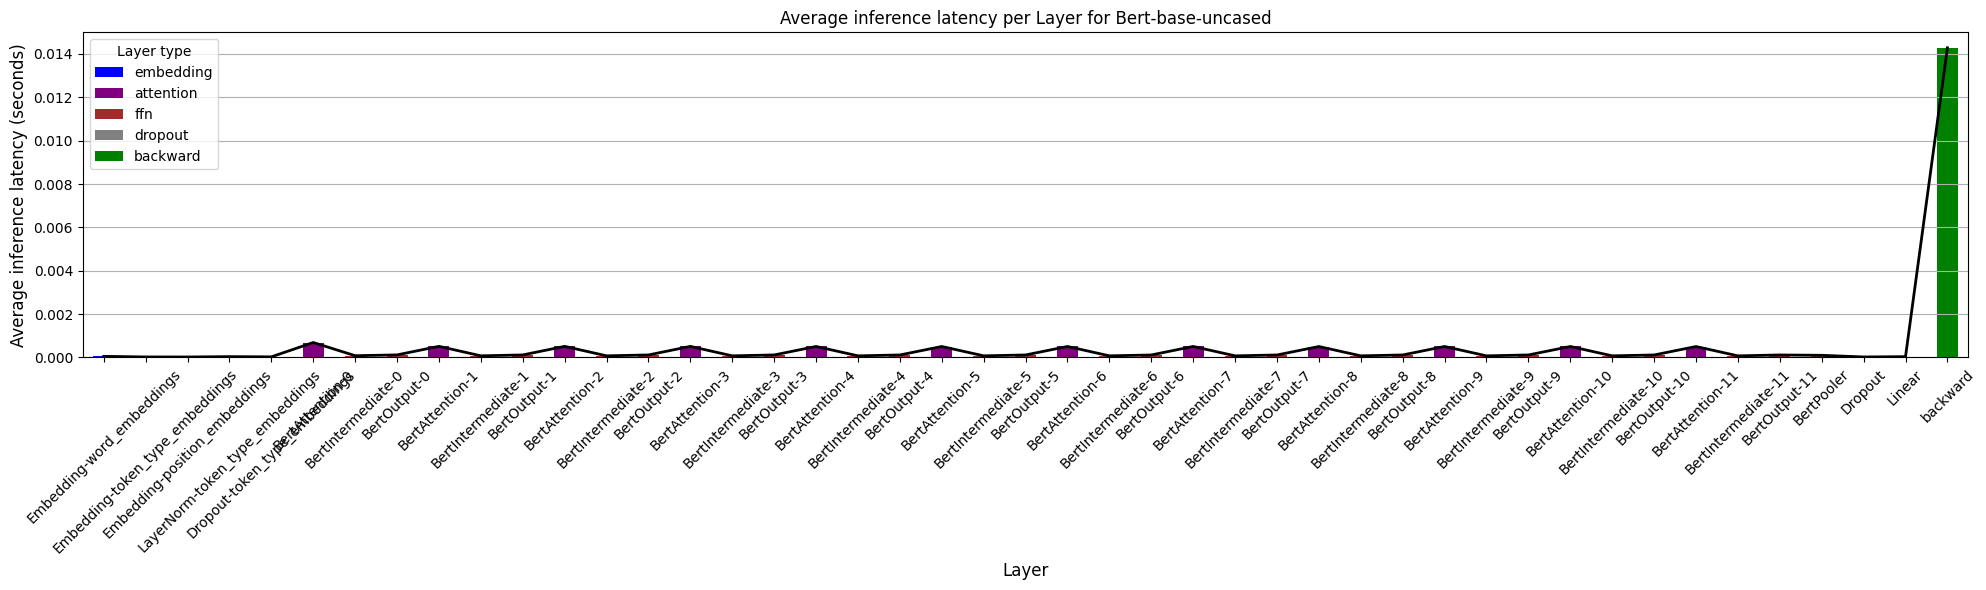

In [26]:
plot_layer_profiling(
    forward_latency_bert, 
    'Bert-base-uncased', 
    backward_res=backward_latency_bert,
    save_file='figures/bert_layer_latency_forward_average.pdf',
    metric='inference latency',
    unit='seconds',
)

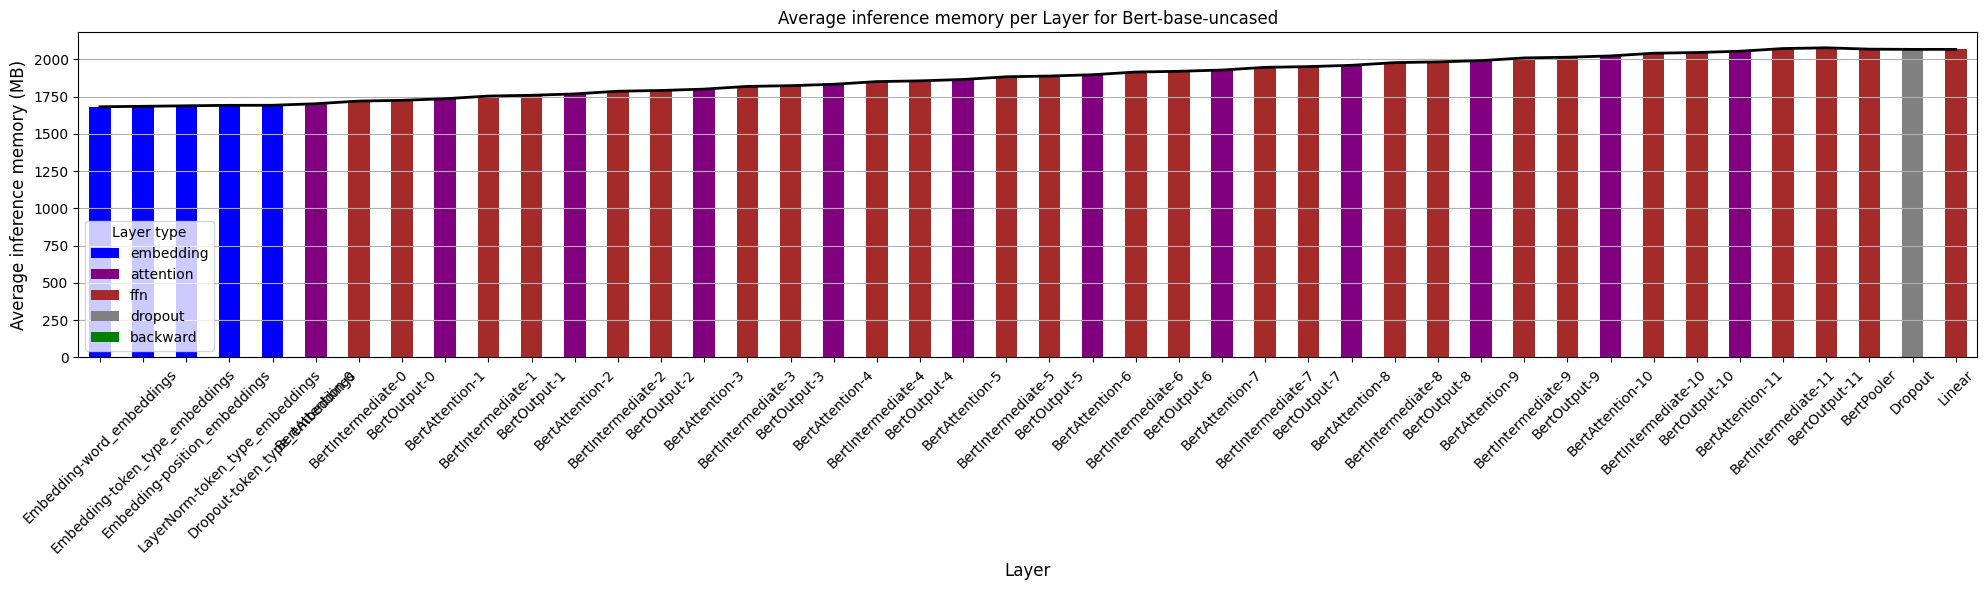

In [27]:
plot_layer_profiling(
    forward_memory_bert/(1024 ** 2), 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_memory_forward_average.pdf',
    metric='inference memory',
    unit='MB',
)

### Testing

In [28]:
output_dir = 'results/text-classification/bert-base-uncased'
forward_input_len_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_input_length.json')))
forward_latency_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_forward_latency.json')))
forward_memory_bert = pd.DataFrame(json.load(open(f'{output_dir}/eval_forward_memory.json')))

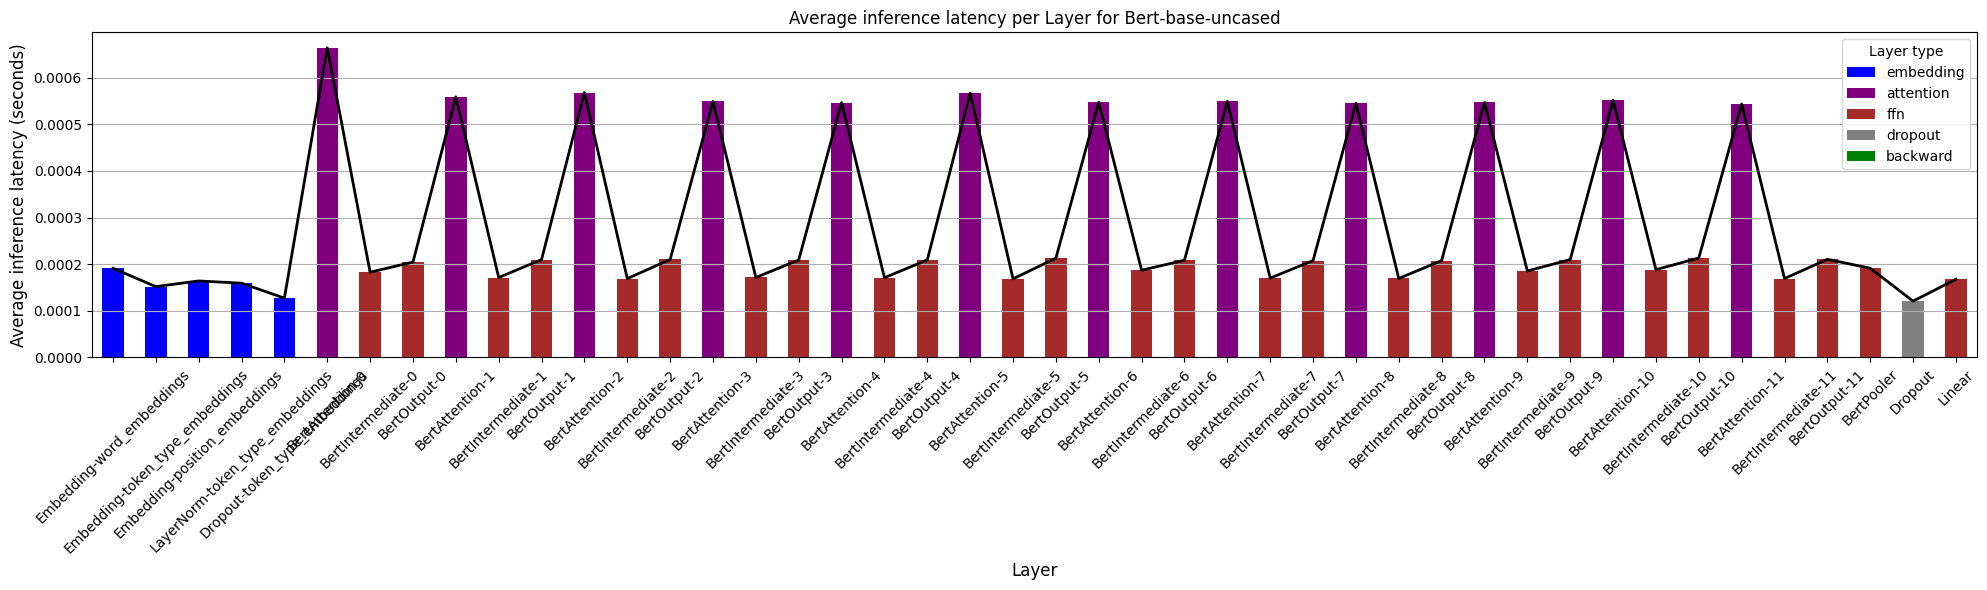

In [29]:
plot_layer_profiling(
    forward_latency_bert, 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_latency_forward_average(eval).pdf',
    metric='inference latency',
    unit='seconds',
)

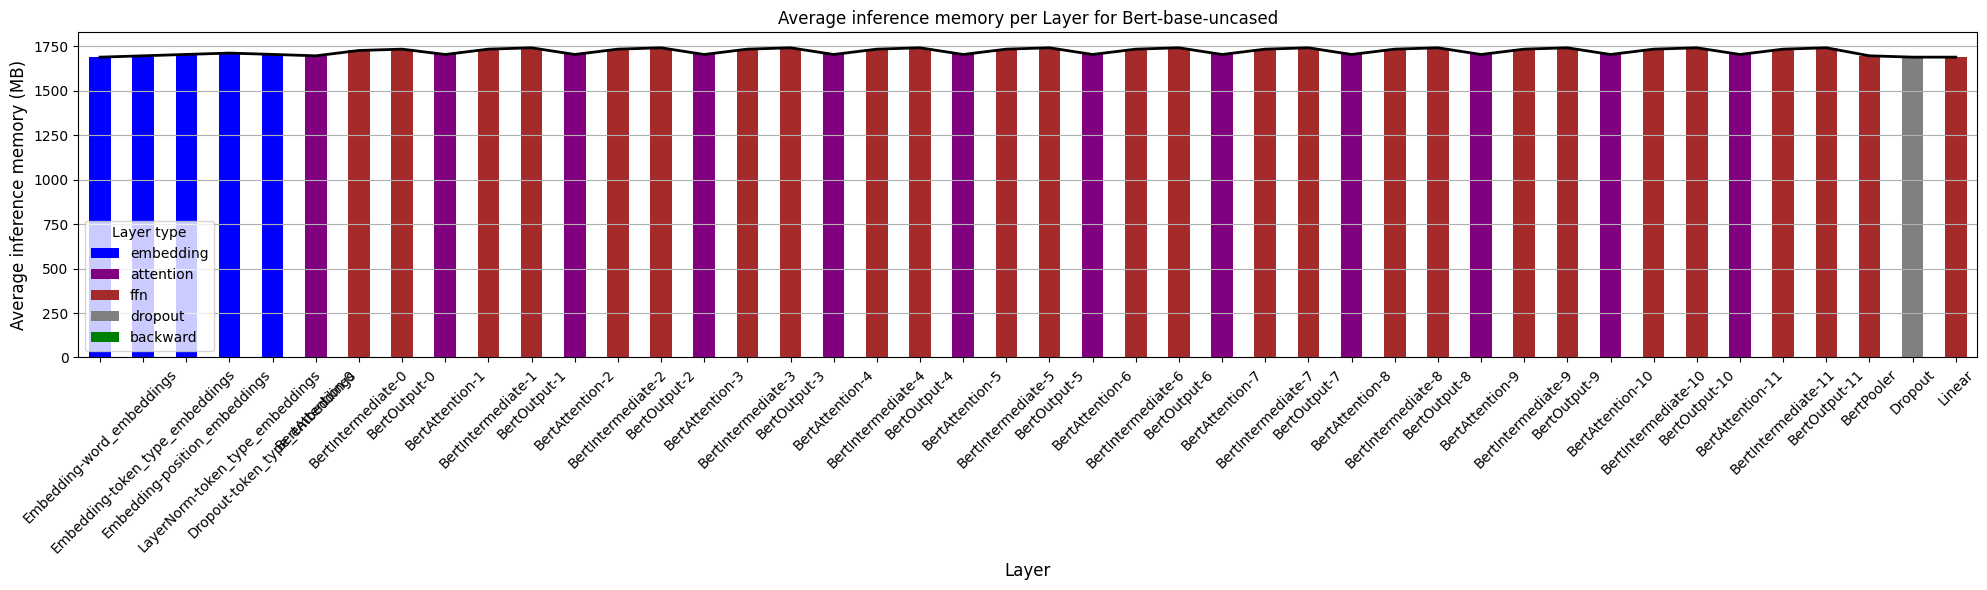

In [30]:
plot_layer_profiling(
    forward_memory_bert/(1024 ** 2), 
    'Bert-base-uncased', 
    save_file='figures/bert_layer_memory_forward_average(eval).pdf',
    metric='inference memory',
    unit='MB',
)

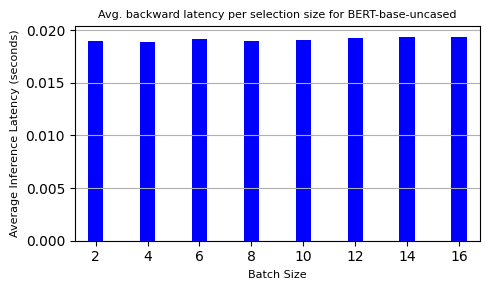

In [27]:
dir = 'results/text-classification/bert-base-uncased'
df = []
selection_sizes = [2, 4, 6, 8, 10, 12, 14, 16]
for batch_size in selection_sizes:
    df.append(json.load(open(f'{dir}/train_backward_latency(batch={batch_size}).json')))
    
df = pd.DataFrame(np.array(df).T, columns=selection_sizes)
df

# Plot the average latency distribution regarding each batch size
plt.figure(figsize=(5, 3))
df.mean().plot(kind='bar', color='blue', width=0.3)
plt.ylabel('Average Inference Latency (seconds)', fontdict={'fontsize': 8})
plt.xlabel('Batch Size', fontdict={'fontsize': 8})
plt.title('Avg. backward latency per selection size for BERT-base-uncased', fontdict={'fontsize': 8})
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figures/bert_backward_latency_selection_size (B).pdf', bbox_inches='tight')

basic-forward times: 78150
grad_accum-forward times: 77600
back_accum-forward times: 77600
basic-backward times: 78150
grad_accum-backward times: 77600
back_accum-backward times: 4850
basic-optimization times: 78150
grad_accum-optimization times: 4850
back_accum-optimization times: 4850


2023-10-05 13:47:23,496 - DEBUG - Assigning font /F1 = '/home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-10-05 13:47:23,555 - DEBUG - Embedding font /home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-10-05 13:47:23,557 - DEBUG - Writing TrueType font.


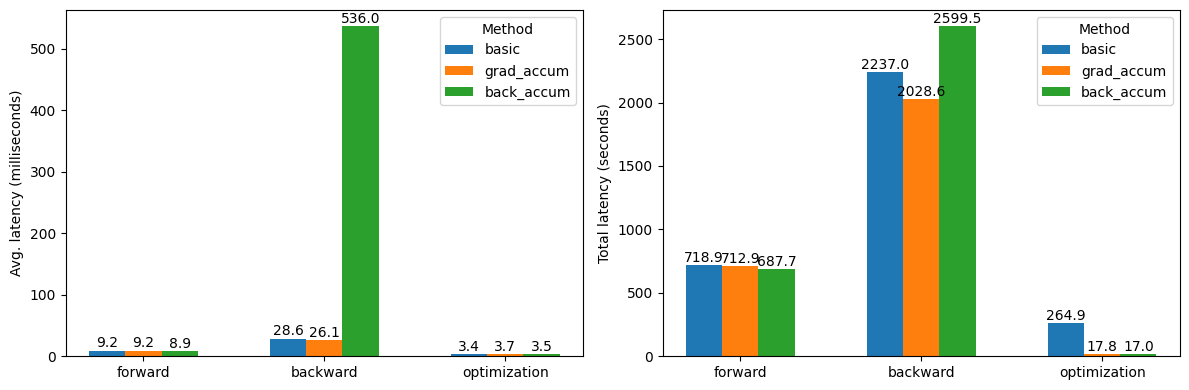

In [41]:
warnings.filterwarnings('ignore')
dir = 'results-profile/text-classification/bert-base-uncased'
batch = 16
data_mean = {}
data_sum = {}

for part in [
    'forward',
    'backward',
    'optimization',
    # 'others',
]:
    if part != 'others':
        data_mean[part] = {}
    data_sum[part] = {}
    for method in [
        'basic',
        'grad_accum',
        'back_accum',
    ]:
        if part == 'others':
            train_df = json.load(open(f'{dir}/{method}/train_results.json'))
            data_sum['others'][method] = train_df['train_runtime'] - data_sum['forward'][method] - data_sum['backward'][method] - data_sum['optimization'][method]
        else:
            accum = 1 if method == 'basic' else batch
            df = json.load(open(f'{dir}/{method}/{part}(batch={batch},accum={accum}).json'))
            mean = np.mean(df)
            sum = np.sum(df)
            print(f'{method}-{part} times: {len(df)}')
            data_mean[part][method] = mean * 1000
            data_sum[part][method] = sum


# fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
width = 0.2

# Plotting avg latencies
parts_mean = list(data_mean.keys())
methods = list(data_mean[parts_mean[0]].keys())
means = [[data_mean[part][method] for method in methods] for part in parts_mean]
ind = np.arange(len(parts_mean))

for i, method in enumerate(methods):
    bars = ax[0].bar(ind + i*width, [means[j][i] for j in range(len(parts_mean))], width, label=method)
    # Add numbers on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                '%.1f' % float(height),
                ha='center', va='bottom')
    

ax[0].set_xticks(ind + width)
ax[0].set_xticklabels(parts_mean)
ax[0].set_ylabel('Avg. latency (milliseconds)')
ax[0].legend(loc='best', title='Method')

# Plotting sum latencies
parts_sum = list(data_sum.keys())
sums = [[data_sum[part][method] for method in methods] for part in parts_sum]
ind = np.arange(len(parts_sum))

for i, method in enumerate(methods):
    bars = ax[1].bar(ind + i*width, [sums[j][i] for j in range(len(parts_sum))], width, label=method)
    # Add numbers on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                '%.1f' % float(height),
                ha='center', va='bottom')
    
ax[1].set_xticks(ind + width)
ax[1].set_xticklabels(parts_sum)
ax[1].set_ylabel('Total latency (seconds)')
ax[1].legend(loc='best', title='Method')

plt.tight_layout()
plt.savefig('figures/train_latency_breakdown.pdf', bbox_inches='tight')
plt.show()

2023-10-05 13:21:10,971 - DEBUG - Assigning font /F1 = '/home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-10-05 13:21:10,990 - DEBUG - Embedding font /home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-10-05 13:21:10,992 - DEBUG - Writing TrueType font.


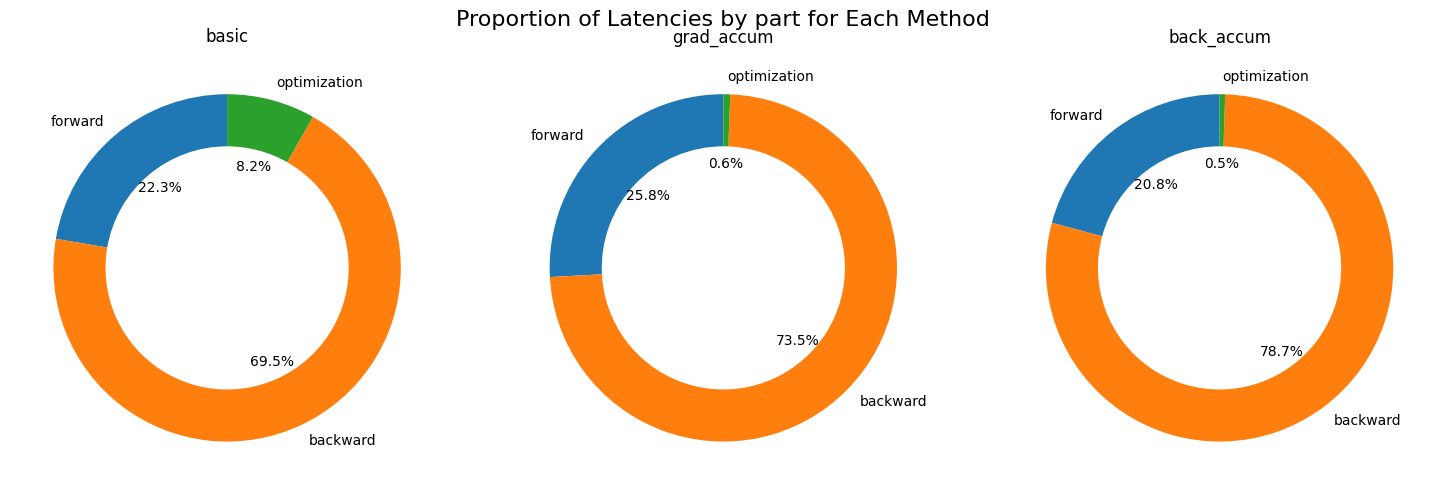

In [40]:
warnings.filterwarnings('ignore')
# Safely getting values from the data dictionary
sums = {method: [data_sum[part][method] for part in parts_sum] for method in methods}

# Plot pie charts for each method
fig, axs = plt.subplots(1, len(methods), figsize=(15, 5))

for i, (method, values) in enumerate(sums.items()):
    axs[i].pie(values, labels=parts_sum, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
    axs[i].set_title(method)

plt.suptitle('Proportion of Latencies by part for Each Method', fontsize=16)
plt.tight_layout()
plt.savefig('figures/train_latency_breakdown_proportion.pdf', bbox_inches='tight')
plt.show()

2023-10-04 08:55:19,729 - DEBUG - Assigning font /F1 = '/home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-10-04 08:55:19,827 - DEBUG - Embedding font /home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-10-04 08:55:19,829 - DEBUG - Writing TrueType font.


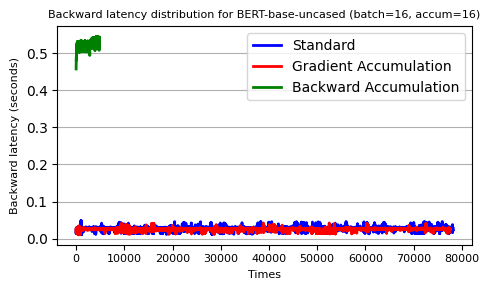

In [29]:
# Ignore warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(5, 3))
plt.plot(basic_latencies, color='blue', linestyle='-', linewidth=2, label='Standard')
plt.plot(grad_accum_latencies, color='red', linestyle='-', linewidth=2, label='Gradient Accumulation')
plt.plot(back_accum_latencies, color='green', linestyle='-', linewidth=2, label='Backward Accumulation')
plt.ylabel('Backward latency (seconds)', fontdict={'fontsize': 8})
plt.xlabel('Times', fontdict={'fontsize': 8})
plt.title(f'Backward latency distribution for BERT-base-uncased (batch={batch}, accum={accum})', fontdict={'fontsize': 8})
plt.xticks(rotation=0, fontsize=8)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/backward_latency_distribution(batch={batch},accum={accum}).pdf', bbox_inches='tight')

2023-10-04 08:55:53,147 - DEBUG - Assigning font /F1 = '/home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-10-04 08:55:53,167 - DEBUG - Embedding font /home/yli927/anaconda3/envs/py3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-10-04 08:55:53,169 - DEBUG - Writing TrueType font.


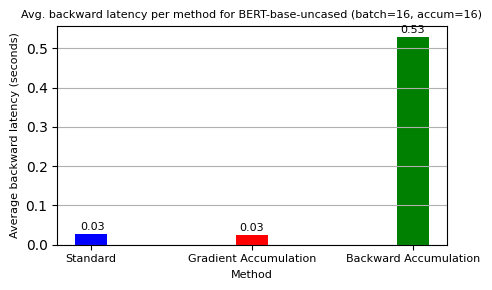

In [30]:
# Plot the average latency distribution regarding each batch size
warnings.filterwarnings('ignore')
plt.figure(figsize=(5, 3))

basic_average = np.mean(basic_latencies)
grad_accum_average = np.mean(grad_accum_latencies)
back_accum_average = np.mean(back_accum_latencies)

plt.bar('Standard', basic_average, color='blue', width=0.2)
plt.bar('Gradient Accumulation', grad_accum_average, color='red', width=0.2)
plt.bar('Backward Accumulation', back_accum_average, color='green', width=0.2)
# Add numbers on top of each bar
plt.text(x=-0.07, y=basic_average+0.01, s=f'{basic_average:.2f}', size=8)
plt.text(x=0.92, y=grad_accum_average+0.01, s=f'{grad_accum_average:.2f}', size=8)
plt.text(x=1.92, y=back_accum_average+0.01, s=f'{back_accum_average:.2f}', size=8)

plt.ylabel('Average backward latency (seconds)', fontdict={'fontsize': 8})
plt.xlabel('Method', fontdict={'fontsize': 8})
plt.title(f'Avg. backward latency per method for BERT-base-uncased (batch={batch}, accum={accum})', fontdict={'fontsize': 8})
plt.xticks(rotation=0, fontsize=8)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f'figures/backward_latency_avg.pdf', bbox_inches='tight') 

In [31]:
print(len(basic_latencies), len(grad_accum_latencies), len(back_accum_latencies))

78150 77600 4850


In [2]:
input_texts = [
    "Hello, my dog is cute",
    "Hello, I like your hat, where did you get it?",
    "What day is it today?",
    "How are you doing?",
    "I am doing great!",
    "The weather is nice today.",
    "Can you please help me with the homework? I am stuck.",
    "I am going to the park.",
    "I am going to the park with my friends.",
    "You are the most beautiful person I have ever met.",
]*100

### Trainer profiler

In [33]:
import json
import pandas as pd

methods = [
    'all',
    'random',
    'entropy',
    'vanilla',
]
dataset = 'mrpc'
results = []
cur_epoch = None
for method in methods:
    trainer_state = json.load(open(f'results/{dataset}/bert-base-cased/{method}/trainer_state.json'))
    for entry in trainer_state['log_history']:
        # print(entry)
        if 'loss' in entry:
            record = {}
            record['method'] = method
            record['epoch'] = entry['epoch']
            record['step'] = entry['step']
            record['train_loss'] = entry['loss']
        elif 'eval_accuracy' in entry:
            record['eval_accuracy'] = entry['eval_accuracy'] * 100
            record['eval_f1'] = entry['eval_f1'] * 100
            results.append(record)
        
results = pd.DataFrame(results)
results

,method,epoch,step,train_loss,eval_accuracy,eval_f1
0,all,1.0,230,0.5752,82.107843,87.079646
1,all,2.0,460,0.3680,77.205882,85.581395
2,all,3.0,690,0.2280,85.294118,90.066225
3,all,4.0,920,0.1502,84.803922,89.455782
4,all,5.0,1150,0.0895,84.803922,89.347079
...,...,...,...,...,...,...
395,vanilla,96.0,22080,0.0000,82.843137,88.333333
396,vanilla,97.0,22310,0.0011,82.598039,88.146912
397,vanilla,98.0,22540,0.0185,82.843137,88.255034
398,vanilla,99.0,22770,0.0000,82.843137,88.215488


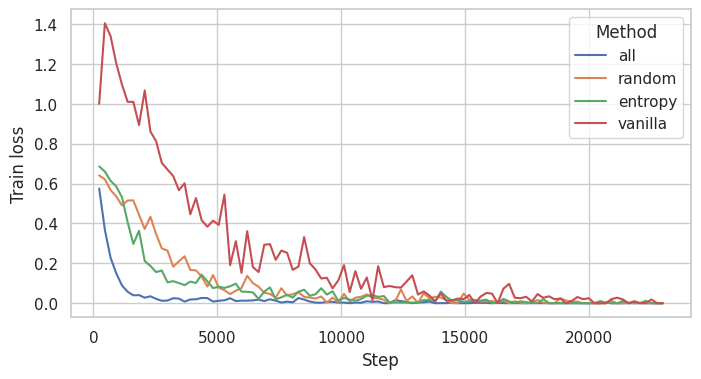

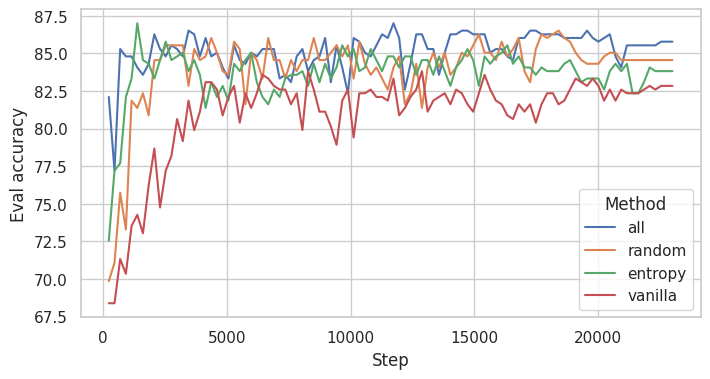

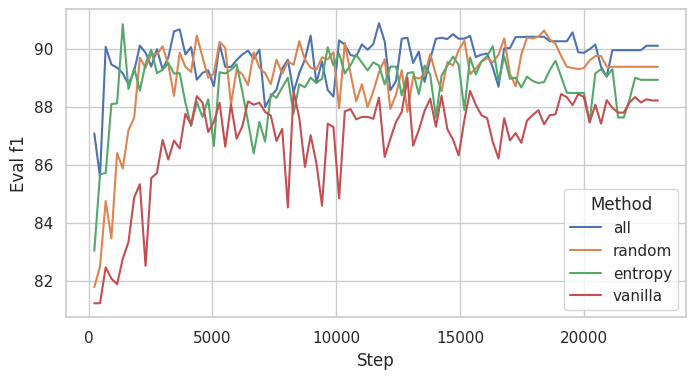

In [37]:
# Plot metric vs. epoch for different methods
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")
# Create a list of metrics to plot
metrics = ['train_loss', 'eval_accuracy', 'eval_f1']
# Plotting
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='step', y=metric, hue='method', data=results)
    # plt.title(f'{metric.replace("_", " ").capitalize()} vs. training step')
    plt.xlabel('Step')
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.legend(title='Method')
    plt.savefig(f'figures/{metric}_vs_step.png', bbox_inches='tight')
    plt.show()

### Different batch sizes

In [39]:
batchs = [2, 4, 6, 8, 10, 12, 14]
method = 'entropy'
dataset = 'mrpc'
results = []
cur_epoch = None
for batch in batchs:
    trainer_state = json.load(open(f'results/{dataset}/bert-base-cased/{method}/{batch}/trainer_state.json'))
    for entry in trainer_state['log_history']:
        # print(entry)
        if 'loss' in entry:
            record = {}
            record['batch_size'] = batch
            record['epoch'] = entry['epoch']
            record['step'] = entry['step']
            record['train_loss'] = entry['loss']
        elif 'eval_accuracy' in entry:
            record['eval_accuracy'] = entry['eval_accuracy'] * 100
            record['eval_f1'] = entry['eval_f1'] * 100
            results.append(record)
        
results = pd.DataFrame(results)
results

,batch_size,epoch,step,train_loss,eval_accuracy,eval_f1
0,2,1.0,230,0.7093,73.039216,83.180428
1,2,2.0,460,0.6850,80.882353,87.254902
2,2,3.0,690,0.6536,80.637255,86.898839
3,2,4.0,920,0.6274,82.352941,87.837838
4,2,5.0,1150,0.6354,84.558824,88.135593
...,...,...,...,...,...,...
695,14,96.0,22080,0.0027,86.029412,90.189329
696,14,97.0,22310,0.0023,84.803922,89.122807
697,14,98.0,22540,0.0005,84.803922,89.122807
698,14,99.0,22770,0.0004,84.803922,89.122807


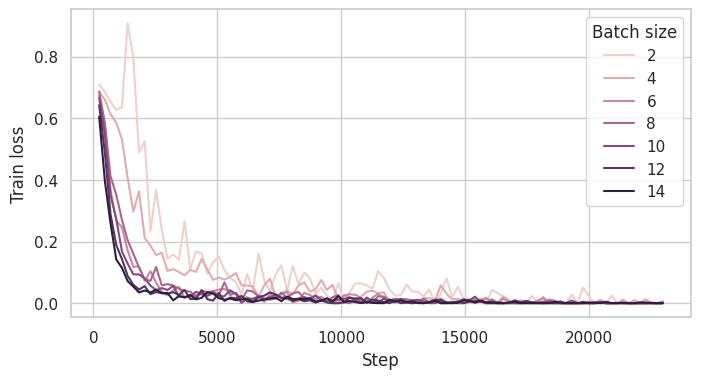

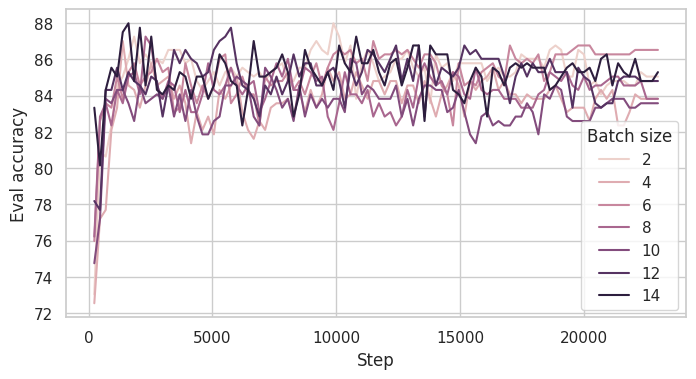

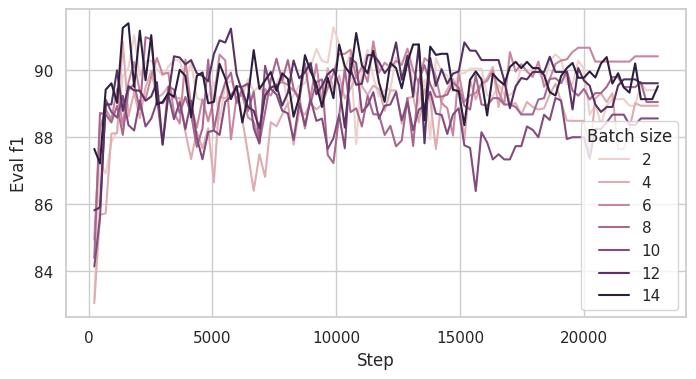

In [42]:
# Set the style of the visualization
sns.set(style="whitegrid")
# Create a list of metrics to plot
metrics = ['train_loss', 'eval_accuracy', 'eval_f1']
# Plotting
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='step', y=metric, hue='batch_size', data=results)
    # plt.title(f'{metric.replace("_", " ").capitalize()} vs. training step')
    plt.xlabel('Step')
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.legend(title='Batch size')
    plt.savefig(f'figures/{metric}_vs_step_entropy.png', bbox_inches='tight')
    plt.show()

### Custom Dataset to return IDX

In [45]:
from datasets import load_dataset, Dataset

dataset = load_dataset('glue', 'mrpc')
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [51]:
len(set(dataset['train']['idx']))

3668

### Loss

In [18]:
import torch
from torch.nn import CrossEntropyLoss

loss1 = CrossEntropyLoss()
loss2 = CrossEntropyLoss(reduction='none')
logits = torch.rand(5, 5000)
l = torch.randint(0, 5000, (5,))
print(loss1(logits.view(-1, 5000), l.view(-1)))
print(loss2(logits.view(-1, 5000), l.view(-1)))
print(loss2(logits.view(-1, 5000), l.view(-1)).mean())

tensor(8.4296)
tensor([8.1717, 8.6061, 8.5894, 8.6332, 8.1476])
tensor(8.4296)


In [25]:
model = torch.nn.Linear(10, 5000)
model.eval()

# with torch.no_grad():
ouputs = model(torch.rand(5, 10))
print(ouputs.shape)
loss = loss2(ouputs, l.view(-1))
print(loss)

torch.Size([5, 5000])
tensor([8.3607, 8.8792, 8.6177, 9.0162, 8.3770], grad_fn=<NllLossBackward0>)


In [26]:
for single_loss in loss:
    print(single_loss)

tensor(8.3607, grad_fn=<UnbindBackward0>)
tensor(8.8792, grad_fn=<UnbindBackward0>)
tensor(8.6177, grad_fn=<UnbindBackward0>)
tensor(9.0162, grad_fn=<UnbindBackward0>)
tensor(8.3770, grad_fn=<UnbindBackward0>)


In [29]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='results/bert-base-cased',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='logs',
    logging_steps=10,
    evaluation_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    greater_is_better=True,
)
args.num_train_epochs = 1

In [32]:
args.num_train_epochs

1